# Importing packages

In [1]:
import pandas as pd
import json
import os
import datetime # used to convert timestamp to datetime and then from datetime to seconds
from common_functionality import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Getting video data from JSON file

In [2]:
data_folder = 'data'
video_data_subfolder = 'video_data'
video_data_full_path = os.path.join(data_folder, video_data_subfolder)

In [2]:
#NOTE: ONLY TO BE USED TO PROCESS THE VIDEOS DONE BY MARK LAWRENCE
data_folder = 'data'
video_data_subfolder = 'video_data_ml'
video_data_full_path = os.path.join(data_folder, video_data_subfolder)

In [3]:
video_data_files = [file for file in os.listdir(video_data_full_path)]

sorted_videos_files = sorted(video_data_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

for index, video_file in enumerate(sorted_videos_files):
    print(f'{index+1}: {video_file}')

1: video_1.json
2: video_2.json
3: video_3.json
4: video_4.json
5: video_5.json
6: video_6.json
7: video_7.json
8: video_8.json
9: video_9.json
10: video_10.json
11: video_11.json
12: video_12.json
13: video_13.json
14: video_14.json
15: video_15.json
16: video_16.json
17: video_17.json
18: video_18.json
19: video_19.json
20: video_20.json
21: video_21.json
22: video_22.json


In [31]:
video_file_chosen = ""
if len(sorted_videos_files) > 0:
    valid_choice = False
    while not valid_choice:
        index_choice = input('Enter index of video to generate analysis visualisations: ')

        if index_choice.isnumeric():
            if int(index_choice) > len(sorted_videos_files) or int(index_choice) <= 0:
                valid_choice = False
                print('Invalid choice!')
            else:
                valid_choice = True
                video_file_chosen = sorted_videos_files[int(index_choice)-1]
                video_chosen_basename = os.path.splitext(video_file_chosen)[0]
                print("Video selected:", video_chosen_basename)
        else:
            valid_choice = False
            print("Index entered is not numeric!")

Video selected: video_14


In [32]:
chosen_video_data_file = os.path.join(video_data_full_path, video_file_chosen)

with open(chosen_video_data_file, 'r') as data_file:
    data = json.load(data_file)

#data

# Validate that video data exists

In [33]:
video_file_base = os.path.splitext(video_file_chosen)[0]
video_data_file_exists = check_if_data_file_exists(video_file_base)

if not video_data_file_exists:
    raise Exception(f'Data file for {video_file_base} does not exist in {video_data_full_path}!')
    exit(0)

roi_list_exists_in_file = validate_roi_list_exists(chosen_video_data_file)

if not roi_list_exists_in_file:
    raise Exception(f'Please ensure that all facial ROIs from {video_file_base} have been extracted before running this!')
    exit(0)

# Generate Dataframe from selected video data

In [34]:
df = pd.DataFrame.from_dict(data['frames_list'])

#df.head()

In [35]:
# Normalize 'rois_list' to expand the nested dictionaries
df_rois = df.explode('rois_list').reset_index(drop=True)  # Ensure lists are split into separate rows
df_rois = pd.concat([df_rois.drop(columns=['rois_list']), df_rois['rois_list'].apply(pd.Series)], axis=1)

df_rois = df_rois.dropna(axis=1, how='all')

# Further split nested dictionaries inside 'facial_encoding' and 'emotion_probabilities'
facial_encoding_df = pd.json_normalize(df_rois['facial_encoding'].dropna())
emotion_probabilities_df = pd.json_normalize(df_rois['emotion_probabilities'].dropna())

# Reindex to align with df_rois
facial_encoding_df.index = df_rois['facial_encoding'].dropna().index
emotion_probabilities_df.index = df_rois['emotion_probabilities'].dropna().index

# Merge them back into the main DataFrame
df_rois = df_rois.join(facial_encoding_df).join(emotion_probabilities_df)

df_rois.rename(columns={emotion: f'{emotion}_prob' for emotion in ['angry', 'happy', 'sad', 'neutral', 'fear', 'surprise', 'disgust']}, inplace=True)
df_rois.rename(columns={f'predicted_{metric}': metric for metric in ['arousal', 'valence']}, inplace=True)

df_rois = df_rois.drop(columns=['facial_encoding', 'emotion_probabilities'])

df_rois = df_rois.loc[:, ['frame_num', 'frame_timestamp', 'num_of_rois', 'roi_num',
       'person_classified', 'emotion_classified', 'person_score',  'angry_prob', 'disgust_prob', 'fear_prob',
       'happy_prob', 'sad_prob', 'surprise_prob', 'neutral_prob', 'entropy', 'arousal', 'valence',
       'x', 'y', 'w', 'h']]

#print(df_rois.columns)

#df_rois.head(10)

In [36]:
df_rois[(df_rois['person_classified'] == 'unknown') & ~df_rois['emotion_classified'].isnull()]

Empty DataFrame
Columns: [frame_num, frame_timestamp, num_of_rois, roi_num, person_classified, emotion_classified, person_score, angry_prob, disgust_prob, fear_prob, happy_prob, sad_prob, surprise_prob, neutral_prob, entropy, arousal, valence, x, y, w, h]
Index: []

[0 rows x 21 columns]

In [37]:
misclassified_emotions = df_rois[(df_rois['person_classified'].isin(['interviewer', 'interviewee'])) & df_rois['emotion_classified'].isnull()]

misclassified_emotions

Empty DataFrame
Columns: [frame_num, frame_timestamp, num_of_rois, roi_num, person_classified, emotion_classified, person_score, angry_prob, disgust_prob, fear_prob, happy_prob, sad_prob, surprise_prob, neutral_prob, entropy, arousal, valence, x, y, w, h]
Index: []

[0 rows x 21 columns]

In [38]:
misclassified_emotion_frames = misclassified_emotions['roi_num'].to_list()

misclassified_emotion_frames

[]

## Saving DataFrame to CSV file for user-friendly view

In [39]:
table_data_path = os.path.join('data', 'video_data_table')

if not os.path.exists(table_data_path):
    os.mkdir(table_data_path)

df_rois.to_csv(os.path.join(table_data_path, f'{video_chosen_basename}.csv'), index_label='frame_index')

In [ ]:
#NOTE: ONLY TO BE USED TO PROCESS THE VIDEOS DONE BY MARK LAWRENCE
table_data_path = os.path.join('data', 'video_data_table_ml')

if not os.path.exists(table_data_path):
    os.mkdir(table_data_path)

df_rois.to_csv(os.path.join(table_data_path, f'{video_chosen_basename}.csv'), index_label='frame_index')

## Loading data from newly created CSV file

In [256]:
df_rois_csv = pd.read_csv(os.path.join(table_data_path, f'{video_chosen_basename}.csv'))

#df_rois_csv[df_rois_csv['person_classified'] == 'unknown']

In [257]:
df_rois_csv['emotion_classified'].isnull().sum()

30

In [258]:
intermission_path = f'data/intermission_data/{video_chosen_basename}.json' if 'ml' not in table_data_path else f'data/intermission_data_ml/{video_chosen_basename}.json'

with open(intermission_path, 'r+') as file:
    intermission_data = json.load(file)

interviewee_name_path = 'data/interviewee_names_data.json' if 'ml' not in table_data_path else 'data/interviewee_names_data_ml.json'

with open(interviewee_name_path, 'r+') as file:
    interviewee_data = json.load(file)

interviewer_name_path = 'data/interviewer_names_data.json' if 'ml' not in table_data_path else 'data/interviewer_names_data_ml.json'

with open(interviewer_name_path, 'r+') as file:
    interviewer_data = json.load(file)

# Graph Visualisation Generation

## Functionality to display values in bar chart

In [259]:
def displayLabels(x,y):
    for i in range(len(x)):
        plt.text(x[i], y[i] + 2, str(y[i]), ha='center', fontsize=10)

## Viewing number of ROIs in each frame

### Bar Chart

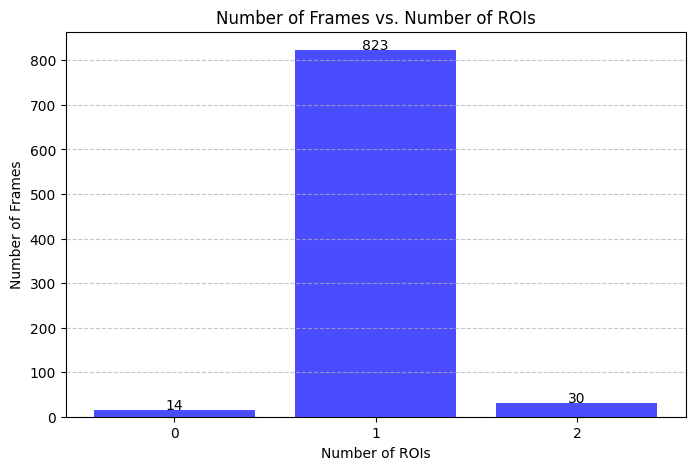

In [260]:
# Ensure 'num_of_rois' is an integer
df_rois_csv['num_of_rois'] = df_rois_csv['num_of_rois'].astype(int)

# Drop duplicates by frame (one entry per frame)
unique_frames = df_rois_csv.drop_duplicates(subset='frame_num')

# Count number of frames for each ROI count
rois_count = Counter(unique_frames['num_of_rois'])

# Extract values for plotting
x_values = list(rois_count.keys())  # Unique num_of_rois values
y_values = list(rois_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x_values, y_values, color='blue', alpha=0.7)
displayLabels(x_values, y_values)
plt.xlabel("Number of ROIs")
plt.ylabel("Number of Frames")
plt.title("Number of Frames vs. Number of ROIs")
plt.xticks(x_values)  # Ensure all categories are labeled
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [261]:
# Verifying that the above bar graph is correct
rois_count

Counter({1: 823, 2: 30, 0: 14})

### Pie Chart

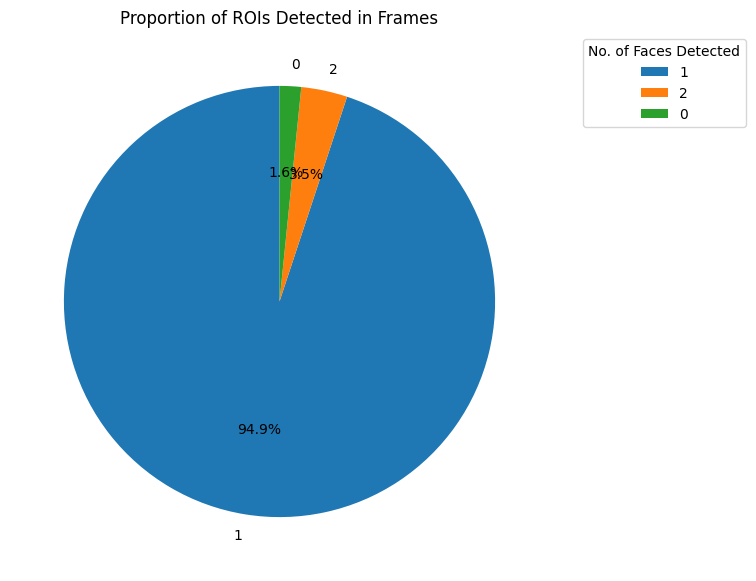

In [262]:
# Ensure 'num_of_rois' is an integer
df_rois_csv['num_of_rois'] = df_rois_csv['num_of_rois'].astype(int)

# Drop duplicates by frame (one entry per frame)
unique_frames = df_rois_csv.drop_duplicates(subset='frame_num')

# Count number of frames for each ROI count
rois_count = Counter(unique_frames['num_of_rois'])

# Extract values for plotting
x_values = list(rois_count.keys())  # Unique num_of_rois values
y_values = list(rois_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(10, 7))
plt.pie(y_values, labels=x_values, autopct='%1.1f%%', startangle=90)
plt.title("Proportion of ROIs Detected in Frames")
plt.legend(title="No. of Faces Detected", loc='upper left', bbox_to_anchor=(1.05, 1))

# Show plot
plt.show()

In [263]:
rois_count

Counter({1: 823, 2: 30, 0: 14})

## Viewing difference in classified person from ROIs (Interviewer vs Interviewee)

### Bar Chart

In [264]:
interviewee_count = 0
interviewer_count = 0

for person in df_rois_csv['person_classified']:
    if person == 'interviewer':
        interviewer_count += 1
    elif person == 'interviewee':
        interviewee_count += 1

print('Interviewers:', interviewer_count)
print('Interviewees:', interviewee_count)

Interviewers: 323
Interviewees: 544


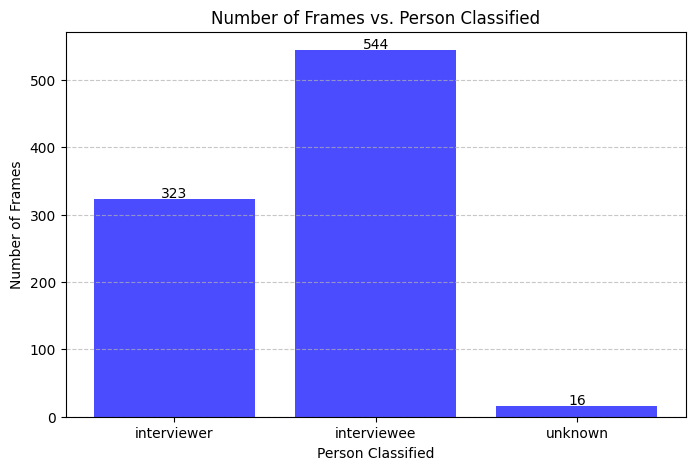

In [265]:
# Extract 'person_classified' from each frame
person_classified_list = []

for roi_counter, person in zip(df_rois_csv['num_of_rois'], df_rois_csv['person_classified']):
    if roi_counter > 0 and pd.isnull(person) == False:
        person_classified_list.append(person)

# Count occurrences of each unique 'num_of_rois' value
pc_count = Counter(person_classified_list)

# Extract values for plotting
x_values = list(pc_count.keys())  # Unique num_of_rois values
y_values = list(pc_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x_values, y_values, color='blue', alpha=0.7)
displayLabels(x_values, y_values)
plt.xlabel("Person Classified")
plt.ylabel("Number of Frames")
plt.title("Number of Frames vs. Person Classified")
plt.xticks(x_values)  # Ensure all categories are labeled
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

### Pie Chart

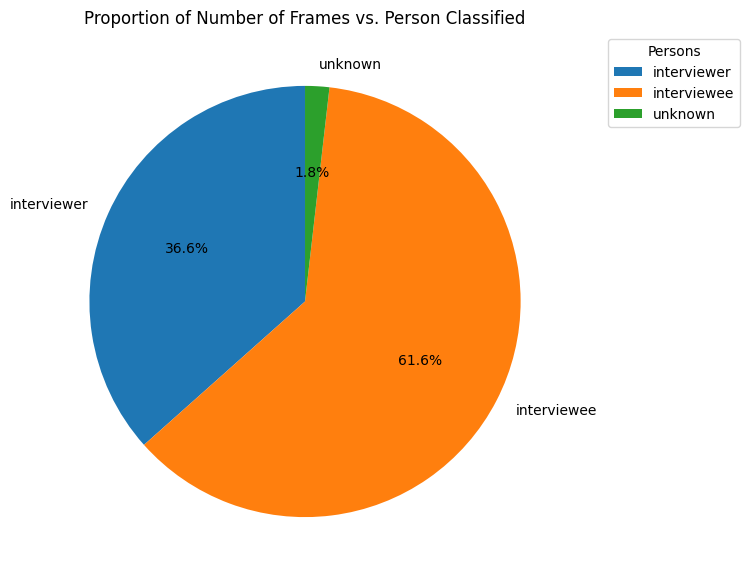

In [266]:
# Extract 'person_classified' from each frame
person_classified_list = []

for roi_counter, person in zip(df_rois_csv['num_of_rois'], df_rois_csv['person_classified']):
    if roi_counter > 0 and pd.isnull(person) == False:
        person_classified_list.append(person)

# Count occurrences of each unique 'num_of_rois' value
person_count = Counter(person_classified_list)

# Extract values for plotting
x_values = list(person_count.keys())  # Unique num_of_rois values
y_values = list(person_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(10, 7))
plt.pie(y_values, labels=x_values, autopct='%1.1f%%', startangle=90)
plt.title("Proportion of Number of Frames vs. Person Classified")
plt.legend(title="Persons", loc='upper left', bbox_to_anchor=(1.05, 1))

# Show plot
plt.show()

In [267]:
# Verifying that the above bar graph is correct
pc_count

Counter({'interviewee': 544, 'interviewer': 323, 'unknown': 16})

## Viewing difference in classified emotions from ROIs

### Bar Chart

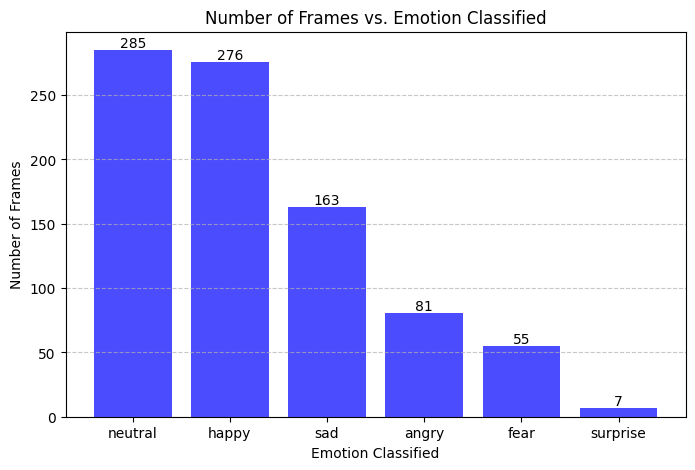

In [268]:
# Extract 'person_classified' from each frame
emotion_classified_list = []

for roi_counter, emotion in zip(df_rois_csv['num_of_rois'], df_rois_csv['emotion_classified']):
    if roi_counter > 0 and pd.isnull(emotion) == False:
        emotion_classified_list.append(emotion)

# Count occurrences of each unique 'num_of_rois' value
emotion_count = Counter(emotion_classified_list)

# Extract values for plotting
x_values = list(emotion_count.keys())  # Unique num_of_rois values
y_values = list(emotion_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x_values, y_values, color='blue', alpha=0.7)
displayLabels(x_values, y_values)
plt.xlabel("Emotion Classified")
plt.ylabel("Number of Frames")
plt.title("Number of Frames vs. Emotion Classified")
plt.xticks(x_values)  # Ensure all categories are labeled
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [269]:
# Verifying that the above bar graph is correct
emotion_count

Counter({'neutral': 285,
         'happy': 276,
         'sad': 163,
         'angry': 81,
         'fear': 55,
         'surprise': 7})

### Pie Chart

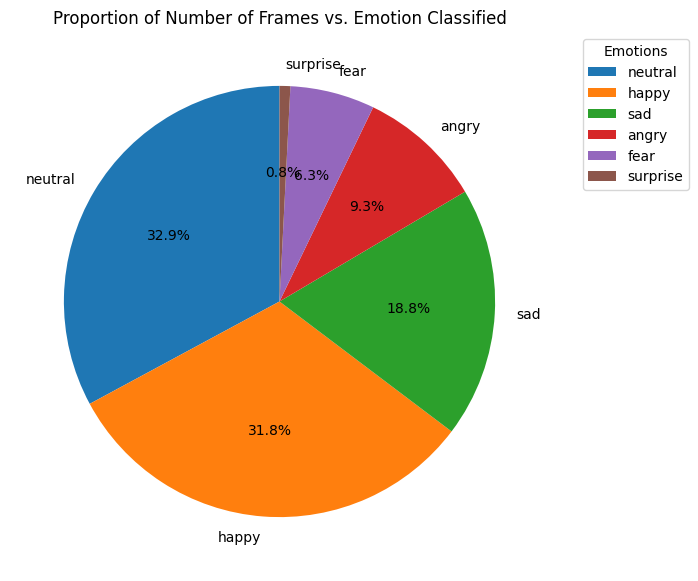

In [270]:
# Extract 'person_classified' from each frame
emotion_classified_list = []

for roi_counter, emotion in zip(df_rois_csv['num_of_rois'], df_rois_csv['emotion_classified']):
    if roi_counter > 0 and pd.isnull(emotion) == False:
        emotion_classified_list.append(emotion)

# Count occurrences of each unique 'num_of_rois' value
emotion_count = Counter(emotion_classified_list)

# Extract values for plotting
x_values = list(emotion_count.keys())  # Unique num_of_rois values
y_values = list(emotion_count.values())  # Count of frames with that num_of_rois

# Plot
plt.figure(figsize=(10, 7))
plt.pie(y_values, labels=x_values, autopct='%1.1f%%', startangle=90)
plt.title("Proportion of Number of Frames vs. Emotion Classified")
plt.legend(title="Emotions", loc='upper left', bbox_to_anchor=(1.05, 1))

# Show plot
plt.show()

In [271]:
emotion_count

Counter({'neutral': 285,
         'happy': 276,
         'sad': 163,
         'angry': 81,
         'fear': 55,
         'surprise': 7})

## Viewing difference in classified emotions from ROIs between Interviewer and Interviewee

### Bar Chart

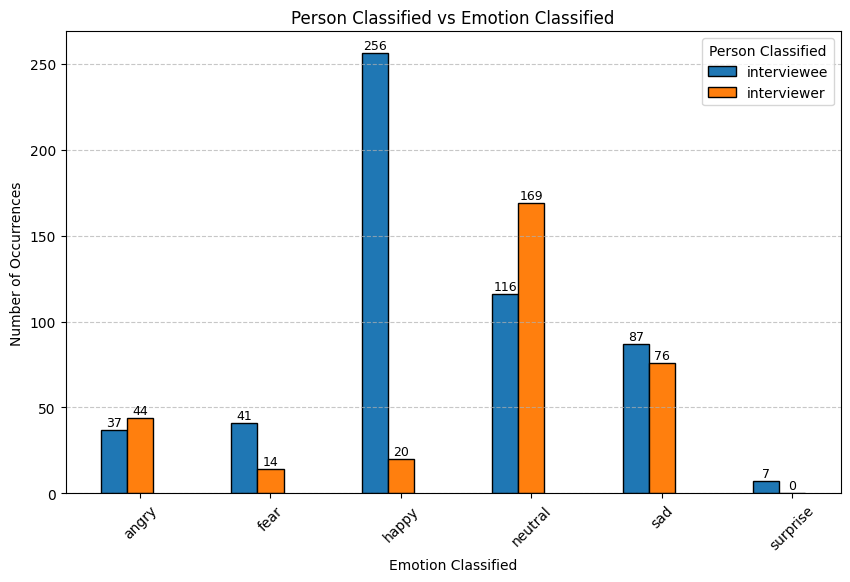

In [272]:
# Extract (person_classified, emotion_classified) pairs
person_emotion_pairs = []

for roi_counter, person, emotion in zip(df_rois_csv['num_of_rois'], df_rois_csv['person_classified'], df_rois_csv['emotion_classified']):
    if roi_counter > 0 and pd.isnull(emotion) == False and pd.isnull(person) == False:
        if person != 'unknown':
            person_emotion_pairs.append((person, emotion))

# Count occurrences of each (person_classified, emotion_classified) pair
person_emotion_count = Counter(person_emotion_pairs)

# Convert to DataFrame
df = pd.DataFrame(person_emotion_count.items(), columns=["Person_Emotion", "Count"])
df["Person"], df["Emotion"] = zip(*df["Person_Emotion"])
df.drop(columns=["Person_Emotion"], inplace=True)

# Pivot the data for a grouped bar plot
df_pivot = df.pivot(index="Emotion", columns="Person", values="Count").fillna(0)

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.2
x = range(len(df_pivot.index))  # Positions for emotions

# Plot each person classified as separate bars
for i, person in enumerate(df_pivot.columns):
    bar_positions = [pos + (i * bar_width) for pos in x]
    bar_heights = df_pivot[person]

    bars = ax.bar(
        [pos + (i * bar_width) for pos in x],  # Offset each bar
        df_pivot[person],
        width=bar_width,
        label=person,
        edgecolor="black"
    )

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=9
        )
    

# Formatting the chart
ax.set_xlabel("Emotion Classified")
ax.set_ylabel("Number of Occurrences")
ax.set_title("Person Classified vs Emotion Classified")
ax.set_xticks([pos + bar_width for pos in x])
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.legend(title="Person Classified")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [273]:
df

Count       Person   Emotion
0     169  interviewer   neutral
1     256  interviewee     happy
2      76  interviewer       sad
3      44  interviewer     angry
4      20  interviewer     happy
5     116  interviewee   neutral
6      87  interviewee       sad
7      37  interviewee     angry
8      41  interviewee      fear
9      14  interviewer      fear
10      7  interviewee  surprise

In [274]:
df[df['Person'] == 'interviewee']

Count       Person   Emotion
1     256  interviewee     happy
5     116  interviewee   neutral
6      87  interviewee       sad
7      37  interviewee     angry
8      41  interviewee      fear
10      7  interviewee  surprise

### Pie Chart

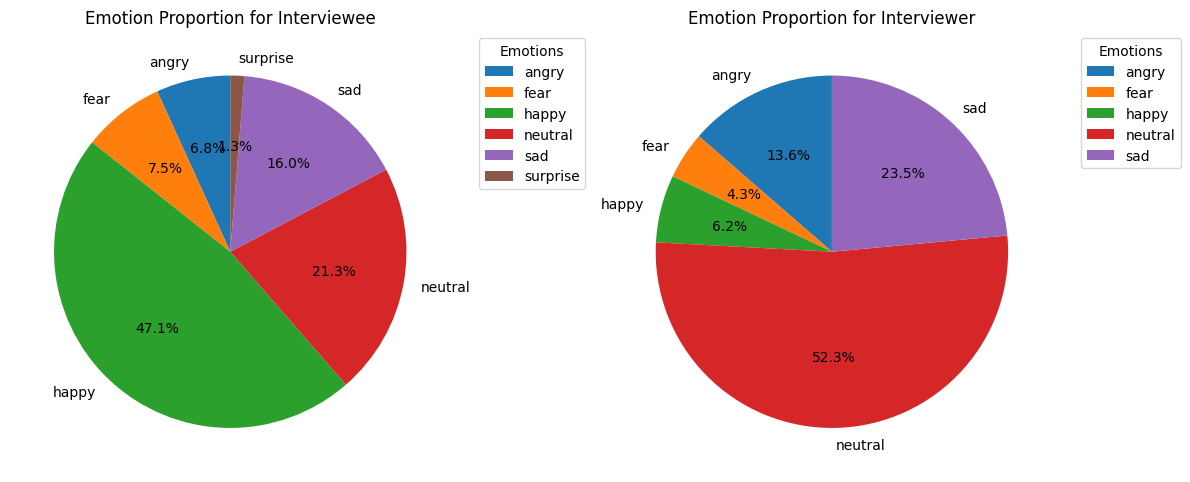

In [275]:
# Grouping data by Person and Emotion, summing the counts
grouped_df = df.groupby(["Person", "Emotion"])["Count"].sum().unstack()

# Plotting pie charts for each person
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (person, counts) in zip(axes, grouped_df.iterrows()):
    counts.dropna(inplace=True)  # Remove NaN values
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.legend(title="Emotions", loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_title(f'Emotion Proportion for {str(person).capitalize()}')

# Display the charts
plt.tight_layout()
plt.show()

In [276]:
person_emotion_count

Counter({('interviewee', 'happy'): 256,
         ('interviewer', 'neutral'): 169,
         ('interviewee', 'neutral'): 116,
         ('interviewee', 'sad'): 87,
         ('interviewer', 'sad'): 76,
         ('interviewer', 'angry'): 44,
         ('interviewee', 'fear'): 41,
         ('interviewee', 'angry'): 37,
         ('interviewer', 'happy'): 20,
         ('interviewer', 'fear'): 14,
         ('interviewee', 'surprise'): 7})

## Display Change in Emotions over Time

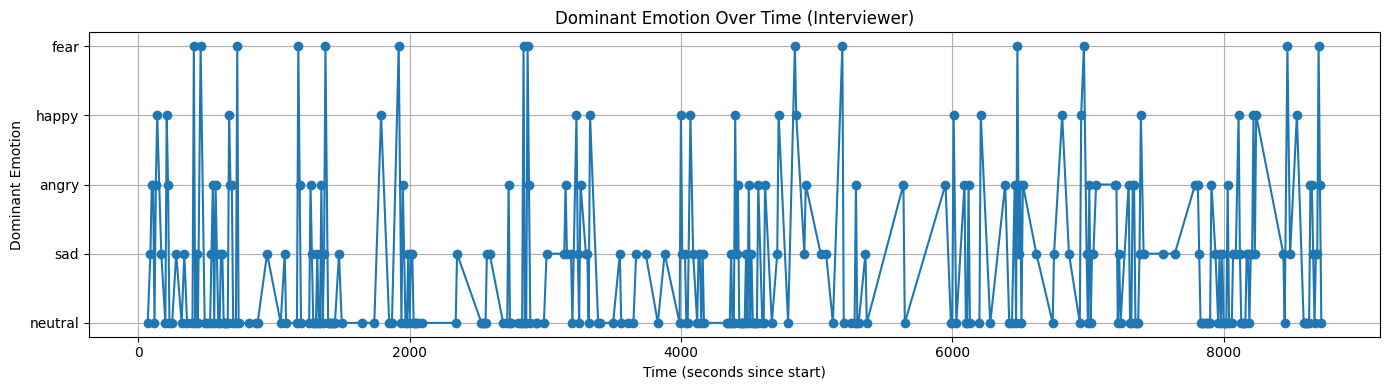

In [277]:
# Filter data for "interviewer" only
df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# Convert frame_timestamp to datetime.timedelta for easier time handling
df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(
    lambda x: sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(":"))))
)

# Set time interval for grouping (in seconds)
interval = 10  # 1 minute

# Assign time bins
df_interviewer["time_bin"] = (df_interviewer["timestamp_seconds"] // interval) * interval

# Group by time_bin and emotion to count occurrences
emotion_counts = df_interviewer.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

# Get dominant emotion per interval
dominant_emotion = emotion_counts.idxmax(axis=1)

emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
int_to_emotion = {v: k for k, v in emotion_to_int.items()}
dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

plt.figure(figsize=(14, 4))
plt.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
plt.yticks(list(int_to_emotion.keys()), list(int_to_emotion.values()))
plt.title("Dominant Emotion Over Time (Interviewer)")
plt.xlabel("Time (seconds since start)")
plt.ylabel("Dominant Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

[('0:00:00', '0:00:33'), ('0:24:46', '0:25:02'), ('0:41:55', '0:42:14'), ('0:56:12', '0:56:28'), ('1:29:00', '1:29:17'), ('1:48:59', '1:50:06'), ('2:25:32', '2:25:41')]
[(33, 1486), (1502, 2515), (2534, 3372), (3388, 5340), (5357, 6539), (6606, 8732)]


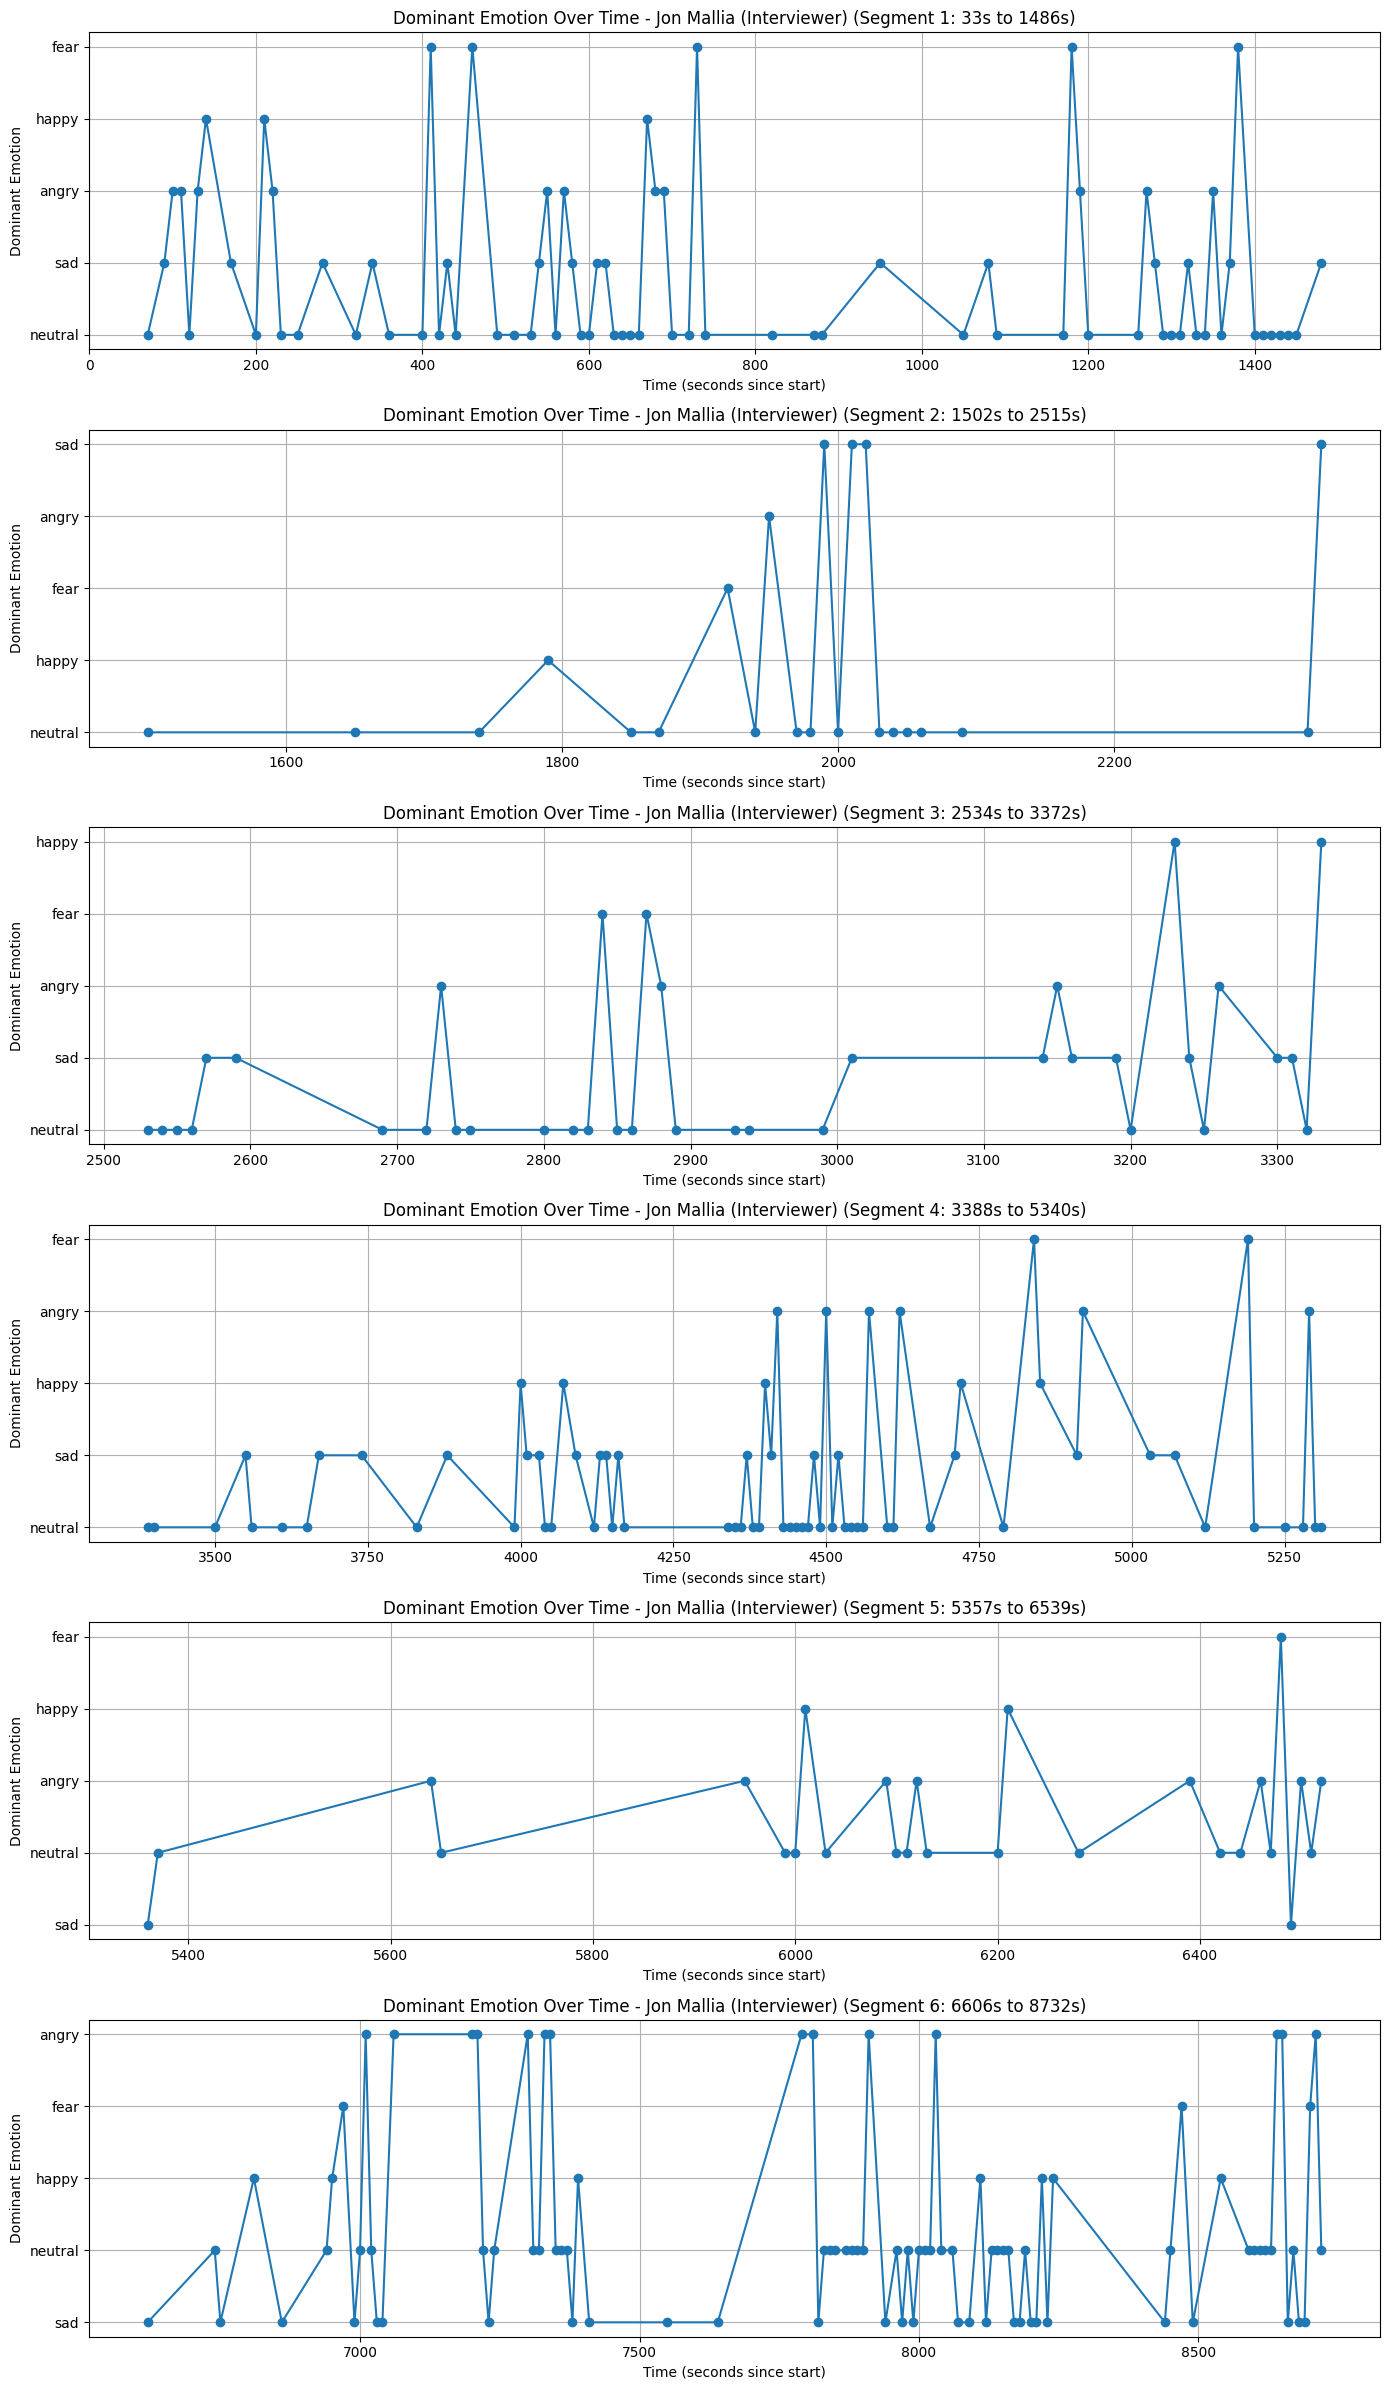

In [278]:
# === 1. Filter data for "interviewer" only
df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data from JSON
intermissions = [(commercial['start_time'], commercial['end_time']) for commercial in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end

# Add final segment if needed
max_time = df_interviewer["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

print(intermissions)
print(non_intermission_segments)

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Plot each segment
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewer[
        (df_interviewer["timestamp_seconds"] > start_sec) &
        (df_interviewer["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by bin and emotion
    emotion_counts = segment_df.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

    # Get dominant emotion per bin
    dominant_emotion = emotion_counts.idxmax(axis=1)
    emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
    int_to_emotion = {v: k for k, v in emotion_to_int.items()}
    dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

    # Plot
    ax = axes[i]
    ax.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
    ax.set_yticks(list(int_to_emotion.keys()))
    ax.set_yticklabels(list(int_to_emotion.values()))
    ax.set_title(f"Dominant Emotion Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Dominant Emotion")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [279]:
# # === 1. Filter data for "interviewer" only
# df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data from JSON
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end

# # Add final segment if needed
# max_time = df_interviewer["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Plot each segment
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewer[
#         (df_interviewer["timestamp_seconds"] > start_sec) &
#         (df_interviewer["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by bin and emotion
#     emotion_counts = segment_df.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

#     # Get dominant emotion per bin
#     dominant_emotion = emotion_counts.idxmax(axis=1)
#     emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
#     int_to_emotion = {v: k for k, v in emotion_to_int.items()}
#     dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

#     # Plot
#     ax = axes[i]
#     ax.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
#     ax.set_yticks(list(int_to_emotion.keys()))
#     ax.set_yticklabels(list(int_to_emotion.values()))
#     ax.set_title(f"Dominant Emotion Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Dominant Emotion")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

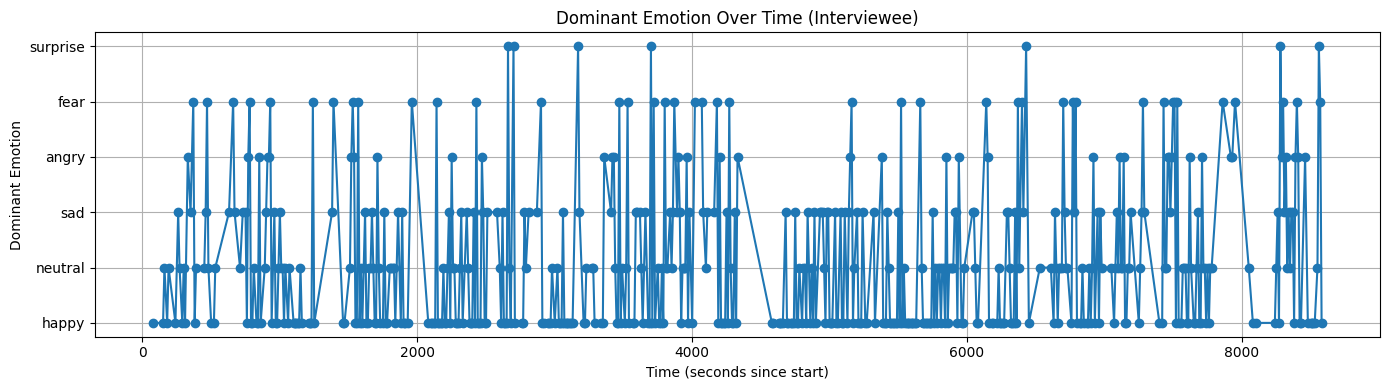

In [280]:
# Filter data for "interviewee" only
df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# Convert frame_timestamp to datetime.timedelta for easier time handling
df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(
    lambda x: sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(":"))))
)

# Set time interval for grouping (in seconds)
interval = 10  # 1 minute

# Assign time bins
df_interviewee["time_bin"] = (df_interviewee["timestamp_seconds"] // interval) * interval

# Group by time_bin and emotion to count occurrences
emotion_counts = df_interviewee.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

# Get dominant emotion per interval
dominant_emotion = emotion_counts.idxmax(axis=1)

emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
int_to_emotion = {v: k for k, v in emotion_to_int.items()}
dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

plt.figure(figsize=(14, 4))
plt.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
plt.yticks(list(int_to_emotion.keys()), list(int_to_emotion.values()))
plt.title("Dominant Emotion Over Time (Interviewee)")
plt.xlabel("Time (seconds since start)")
plt.ylabel("Dominant Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

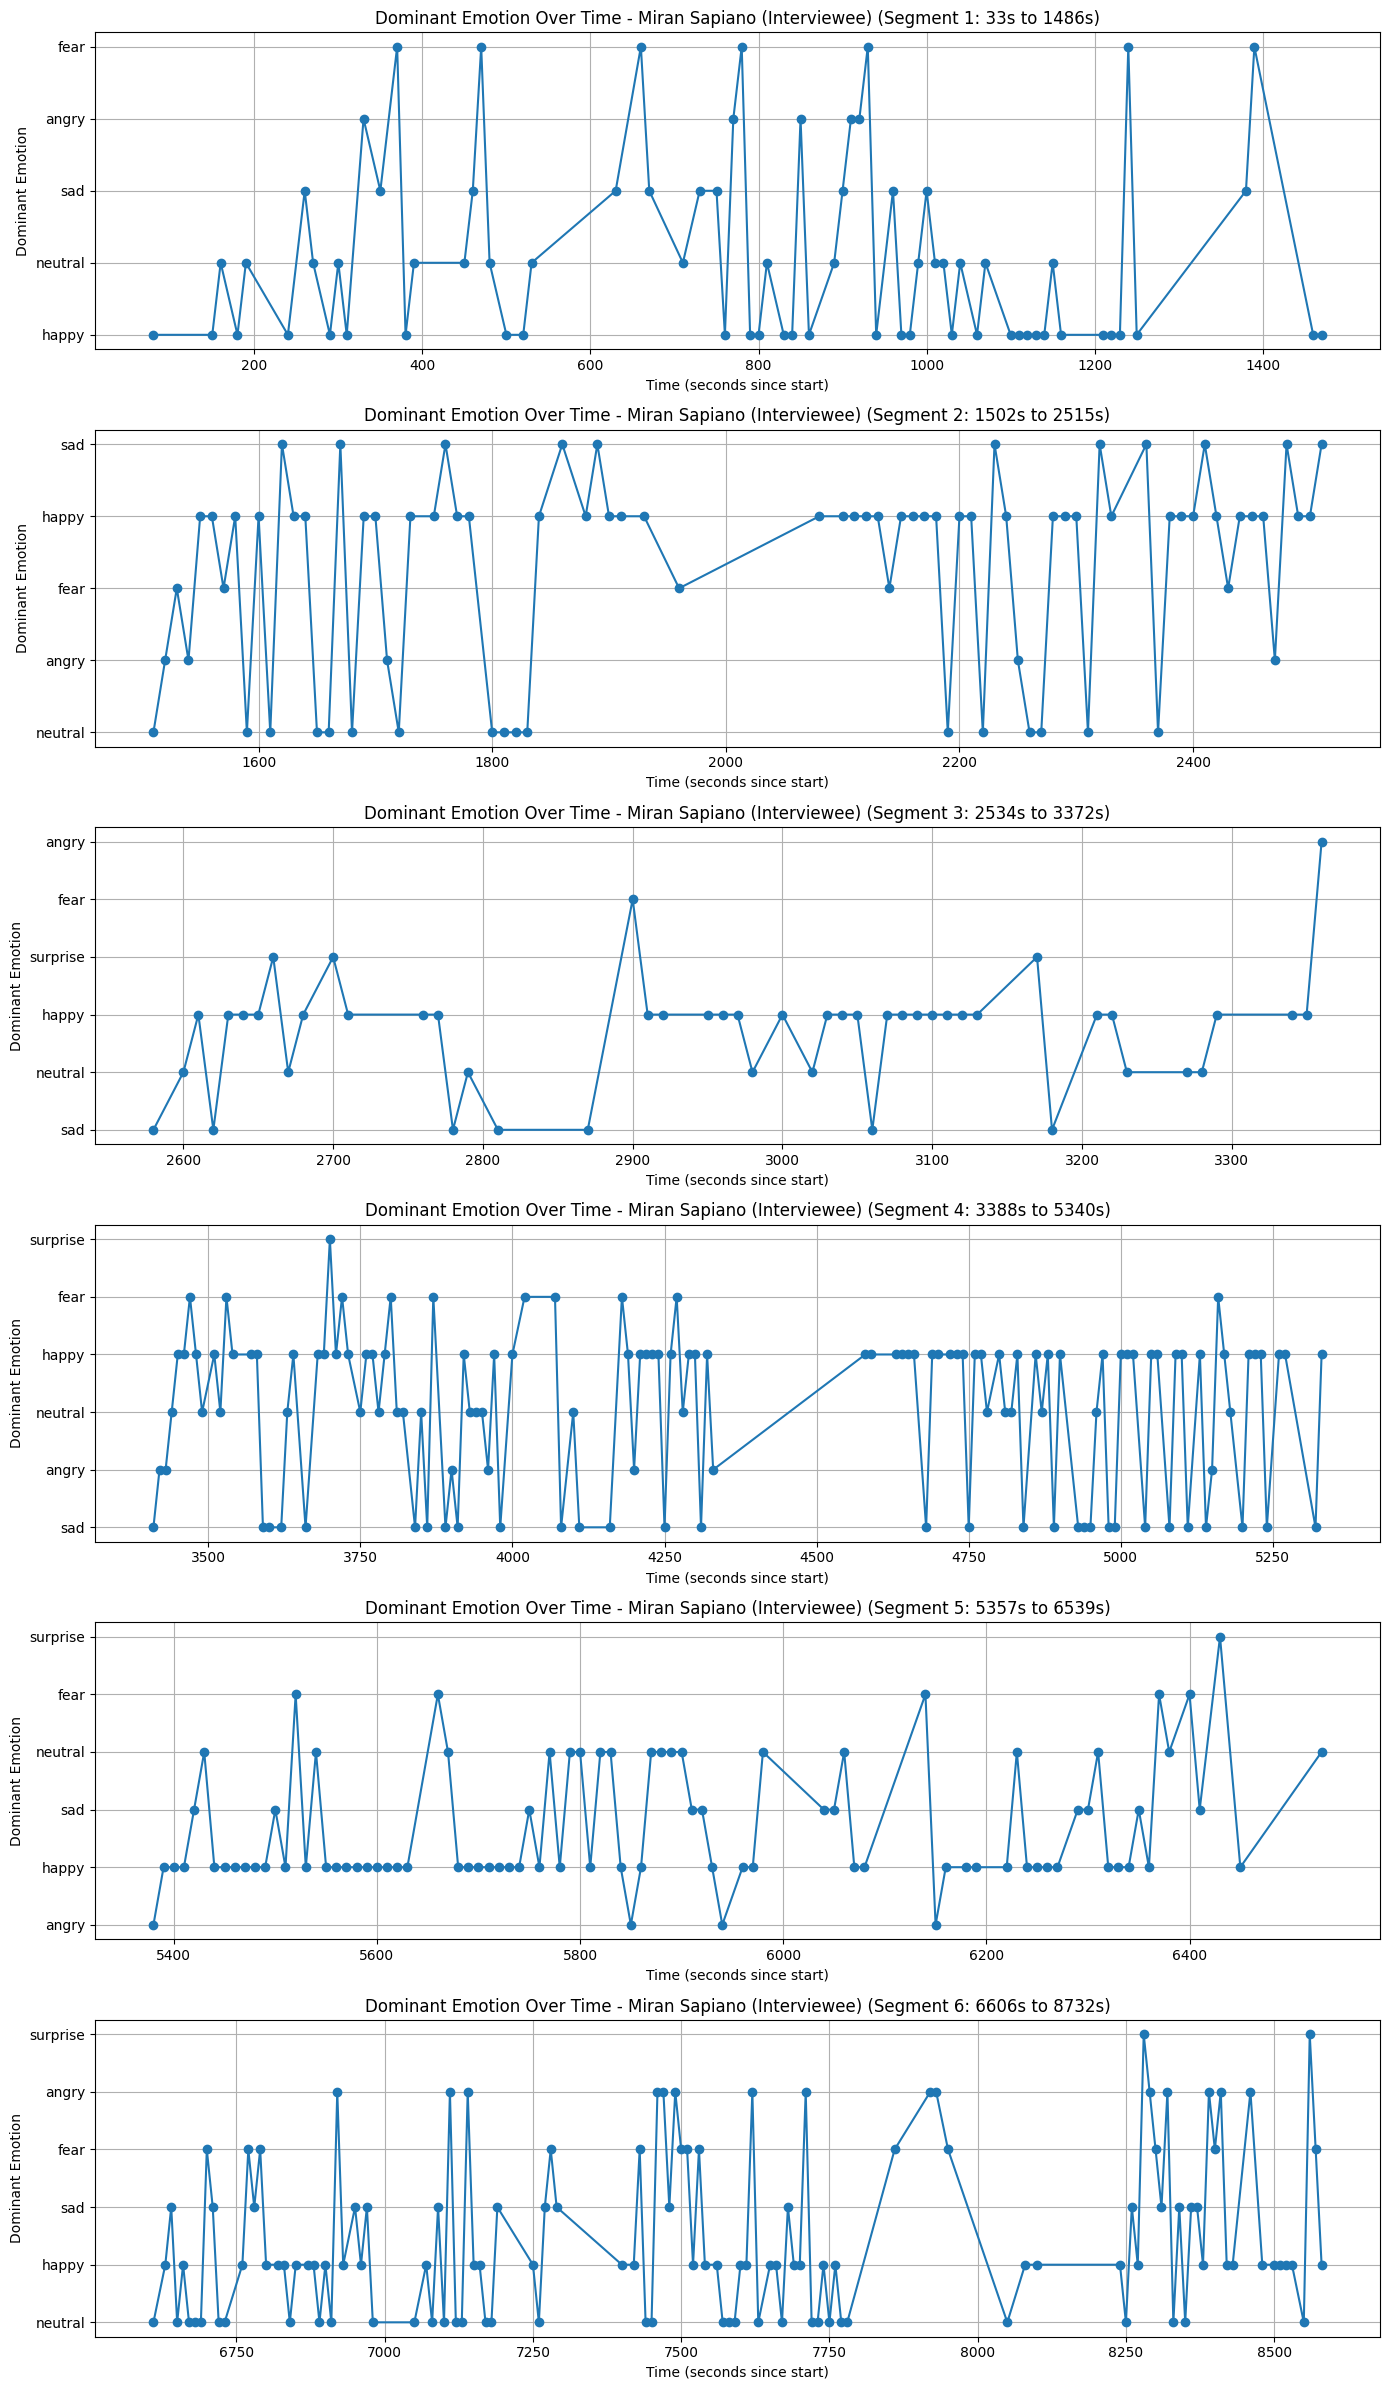

In [281]:
# === 1. Filter data for "interviewee" only
df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data from JSON
intermissions = [(commercial['start_time'], commercial['end_time']) for commercial in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end

# Add final segment if needed
max_time = df_interviewer["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Plot each segment
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewee[
        (df_interviewee["timestamp_seconds"] > start_sec) &
        (df_interviewee["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by bin and emotion
    emotion_counts = segment_df.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

    # Get dominant emotion per bin
    dominant_emotion = emotion_counts.idxmax(axis=1)
    emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
    int_to_emotion = {v: k for k, v in emotion_to_int.items()}
    dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

    # Plot
    ax = axes[i]
    ax.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
    ax.set_yticks(list(int_to_emotion.keys()))
    ax.set_yticklabels(list(int_to_emotion.values()))
    ax.set_title(f"Dominant Emotion Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Dominant Emotion")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [282]:
# # === 1. Filter data for "interviewer" only
# df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data from JSON
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end

# # Add final segment if needed
# max_time = df_interviewer["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Plot each segment
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewee[
#         (df_interviewee["timestamp_seconds"] > start_sec) &
#         (df_interviewee["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by bin and emotion
#     emotion_counts = segment_df.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)

#     # Get dominant emotion per bin
#     dominant_emotion = emotion_counts.idxmax(axis=1)
#     emotion_to_int = {emotion: i for i, emotion in enumerate(dominant_emotion.unique())}
#     int_to_emotion = {v: k for k, v in emotion_to_int.items()}
#     dominant_emotion_numeric = dominant_emotion.map(emotion_to_int)

#     # Plot
#     ax = axes[i]
#     ax.plot(dominant_emotion.index, dominant_emotion_numeric, marker='o', linestyle='-')
#     ax.set_yticks(list(int_to_emotion.keys()))
#     ax.set_yticklabels(list(int_to_emotion.values()))
#     ax.set_title(f"Dominant Emotion Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Dominant Emotion")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()

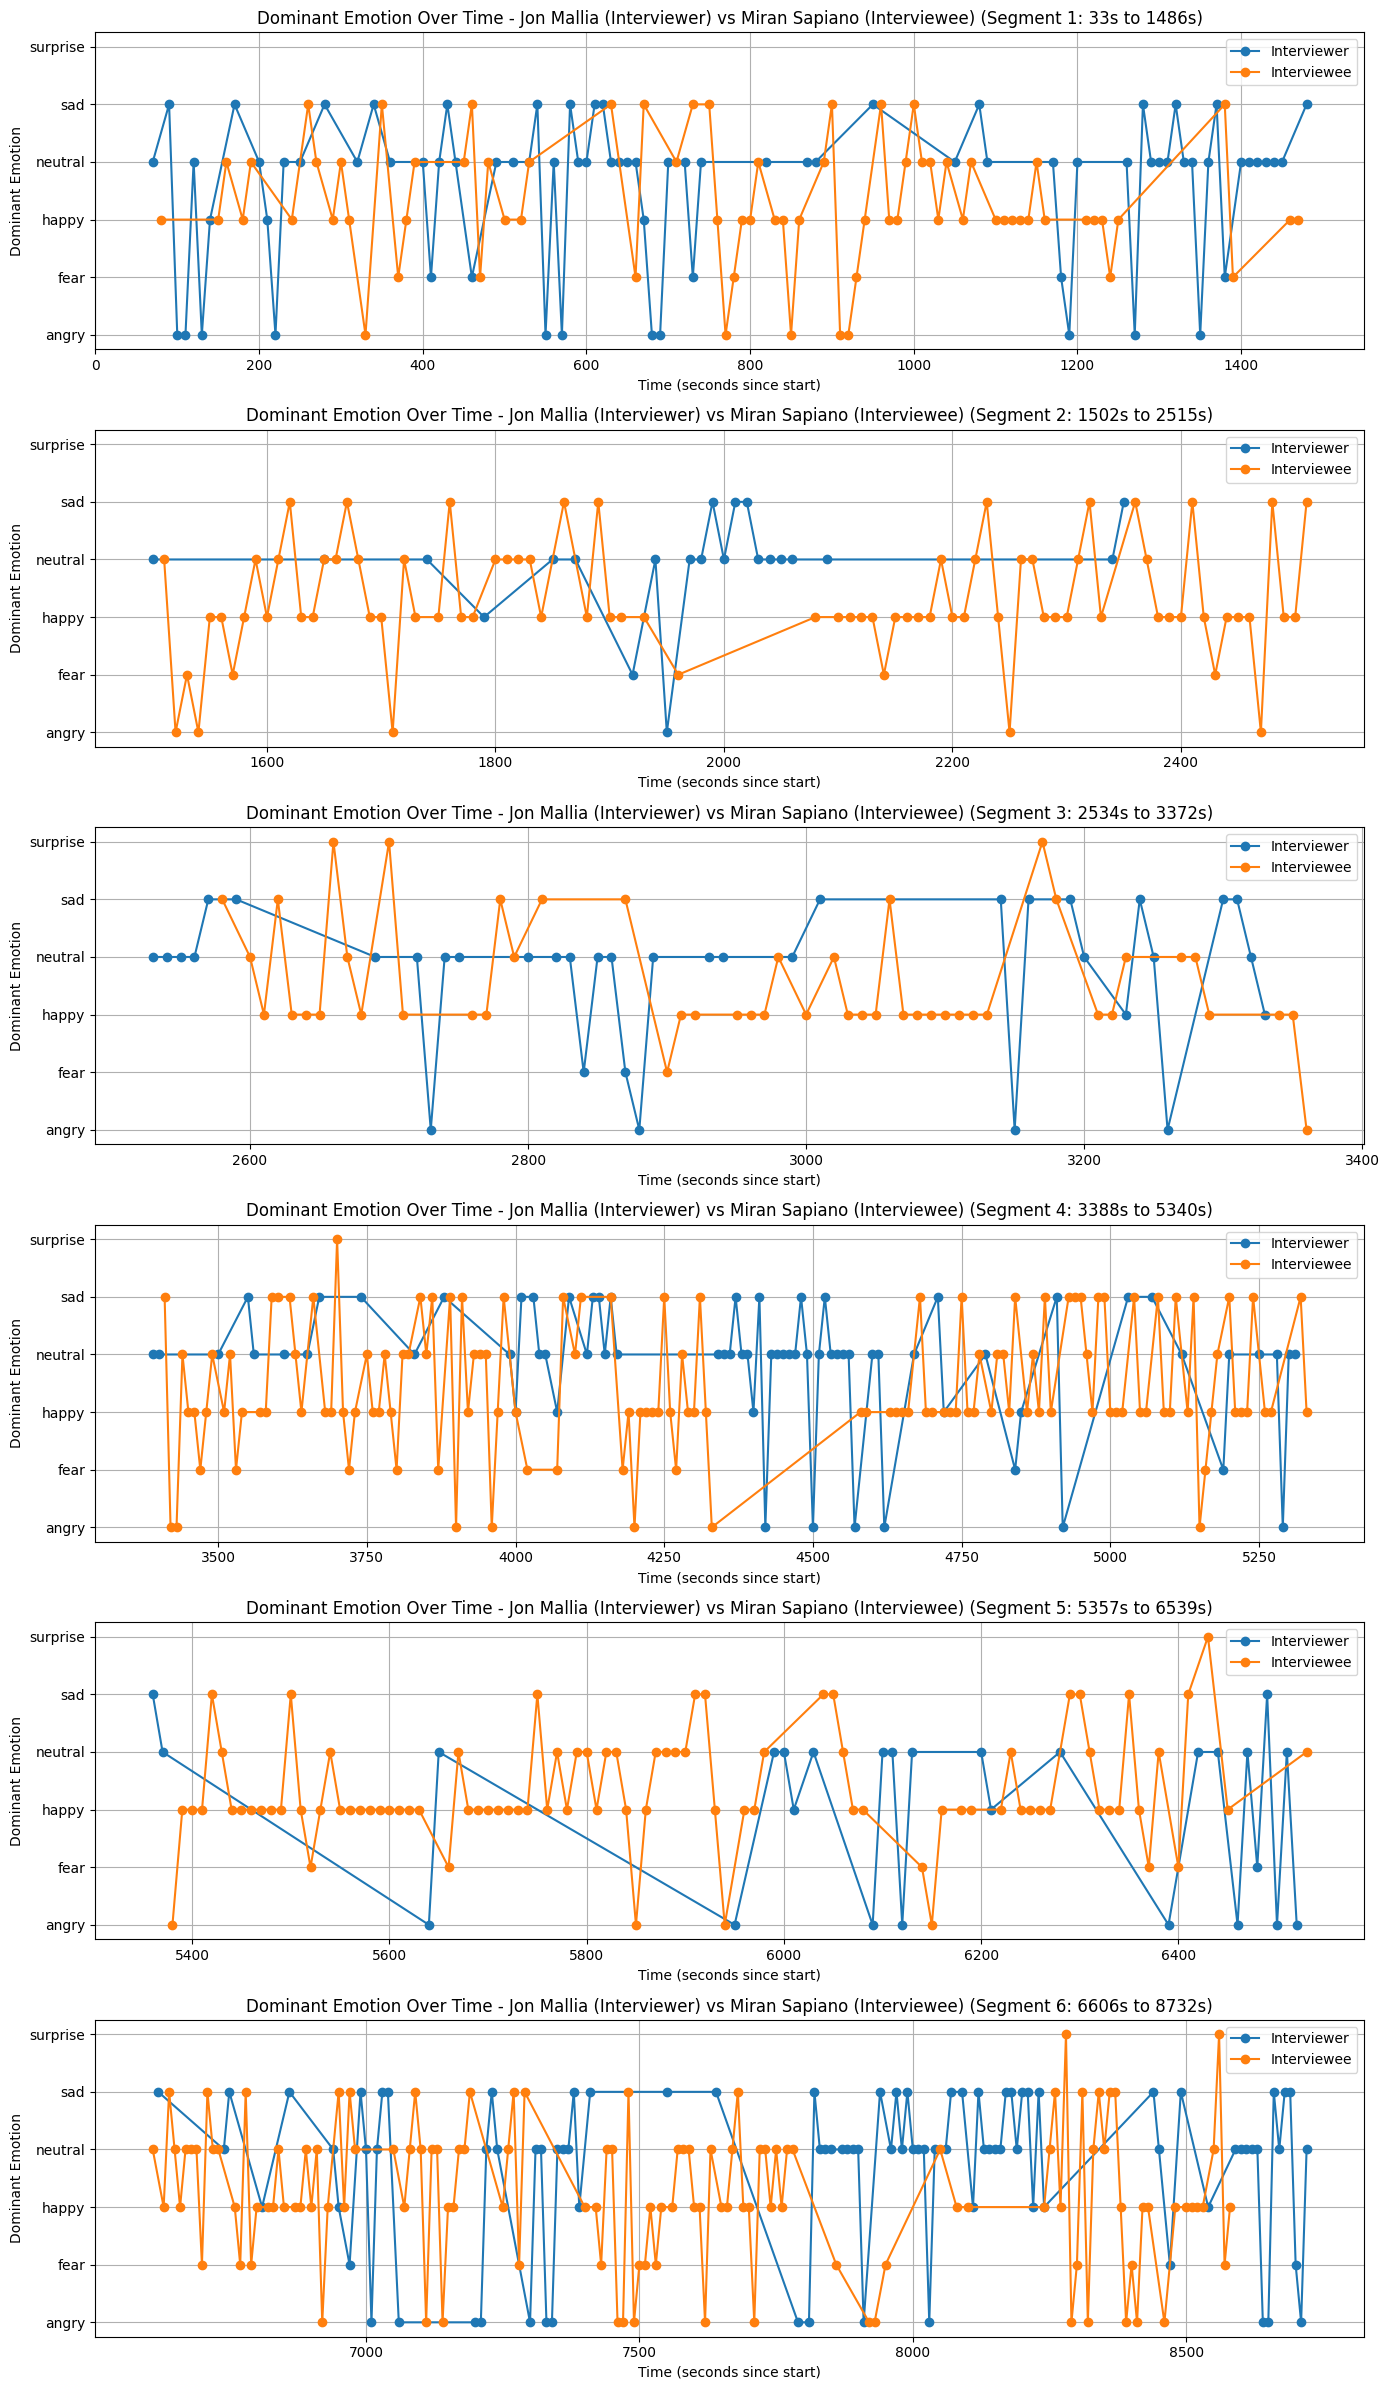

In [283]:
# === Utility: Convert time string to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)
    h, m, s = parts
    return h * 3600 + m * 60 + s

# === Configuration
interval = 10  # binning interval (seconds)

# === Step 1: Prepare Data
df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()
df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)
df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# === Step 2: Handle Intermission Data
intermissions = [(commercial['start_time'], commercial['end_time']) for commercial in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end

max_time = max(df_interviewer["timestamp_seconds"].max(), df_interviewee["timestamp_seconds"].max())
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === Step 3: Establish Full Emotion Set for Consistent Y-axis
all_emotions = sorted(set(df_interviewer["emotion_classified"]) | set(df_interviewee["emotion_classified"]))
emotion_to_int = {emotion: i for i, emotion in enumerate(all_emotions)}
int_to_emotion = {v: k for k, v in emotion_to_int.items()}

# === Step 4: Plotting
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=True)

if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    ax = axes[i]

    # INTERVIEWER SEGMENT
    seg_i = df_interviewer[
        (df_interviewer["timestamp_seconds"] > start_sec) &
        (df_interviewer["timestamp_seconds"] <= end_sec)
    ].copy()
    seg_i["time_bin"] = (seg_i["timestamp_seconds"] // interval) * interval
    emotion_i = seg_i.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)
    if not emotion_i.empty:
        dom_i = emotion_i.idxmax(axis=1).map(emotion_to_int)
        ax.plot(dom_i.index, dom_i.values, marker='o', linestyle='-', label='Interviewer')

    # INTERVIEWEE SEGMENT
    seg_e = df_interviewee[
        (df_interviewee["timestamp_seconds"] > start_sec) &
        (df_interviewee["timestamp_seconds"] <= end_sec)
    ].copy()
    seg_e["time_bin"] = (seg_e["timestamp_seconds"] // interval) * interval
    emotion_e = seg_e.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)
    if not emotion_e.empty:
        dom_e = emotion_e.idxmax(axis=1).map(emotion_to_int)
        ax.plot(dom_e.index, dom_e.values, marker='o', linestyle='-', label='Interviewee')

    # Axis and Labels
    ax.set_title(f"Dominant Emotion Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) vs {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Dominant Emotion")
    ax.set_yticks(list(int_to_emotion.keys()))
    ax.set_yticklabels(list(int_to_emotion.values()))
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [284]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # === Utility: Convert time string to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# # === Configuration
# interval = 10  # binning interval (seconds)

# # === Step 1: Prepare Data
# df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()
# df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)
# df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# # === Step 2: Handle Intermission Data
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end

# max_time = max(df_interviewer["timestamp_seconds"].max(), df_interviewee["timestamp_seconds"].max())
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === Step 3: Establish Full Emotion Set for Consistent Y-axis
# all_emotions = sorted(set(df_interviewer["emotion_classified"]) | set(df_interviewee["emotion_classified"]))
# emotion_to_int = {emotion: i for i, emotion in enumerate(all_emotions)}
# int_to_emotion = {v: k for k, v in emotion_to_int.items()}

# # === Step 4: Plotting
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=True)

# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     ax = axes[i]

#     # INTERVIEWER SEGMENT
#     seg_i = df_interviewer[
#         (df_interviewer["timestamp_seconds"] > start_sec) &
#         (df_interviewer["timestamp_seconds"] <= end_sec)
#     ].copy()
#     seg_i["time_bin"] = (seg_i["timestamp_seconds"] // interval) * interval
#     emotion_i = seg_i.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)
#     if not emotion_i.empty:
#         dom_i = emotion_i.idxmax(axis=1).map(emotion_to_int)
#         ax.plot(dom_i.index, dom_i.values, marker='o', linestyle='-', label='Interviewer')

#     # INTERVIEWEE SEGMENT
#     seg_e = df_interviewee[
#         (df_interviewee["timestamp_seconds"] > start_sec) &
#         (df_interviewee["timestamp_seconds"] <= end_sec)
#     ].copy()
#     seg_e["time_bin"] = (seg_e["timestamp_seconds"] // interval) * interval
#     emotion_e = seg_e.groupby(["time_bin", "emotion_classified"]).size().unstack(fill_value=0)
#     if not emotion_e.empty:
#         dom_e = emotion_e.idxmax(axis=1).map(emotion_to_int)
#         ax.plot(dom_e.index, dom_e.values, marker='o', linestyle='-', label='Interviewee')

#     # Axis and Labels
#     ax.set_title(f"Dominant Emotion Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) vs {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Dominant Emotion")
#     ax.set_yticks(list(int_to_emotion.keys()))
#     ax.set_yticklabels(list(int_to_emotion.values()))
#     ax.grid(True)
#     ax.legend()

# plt.tight_layout()
# plt.show()


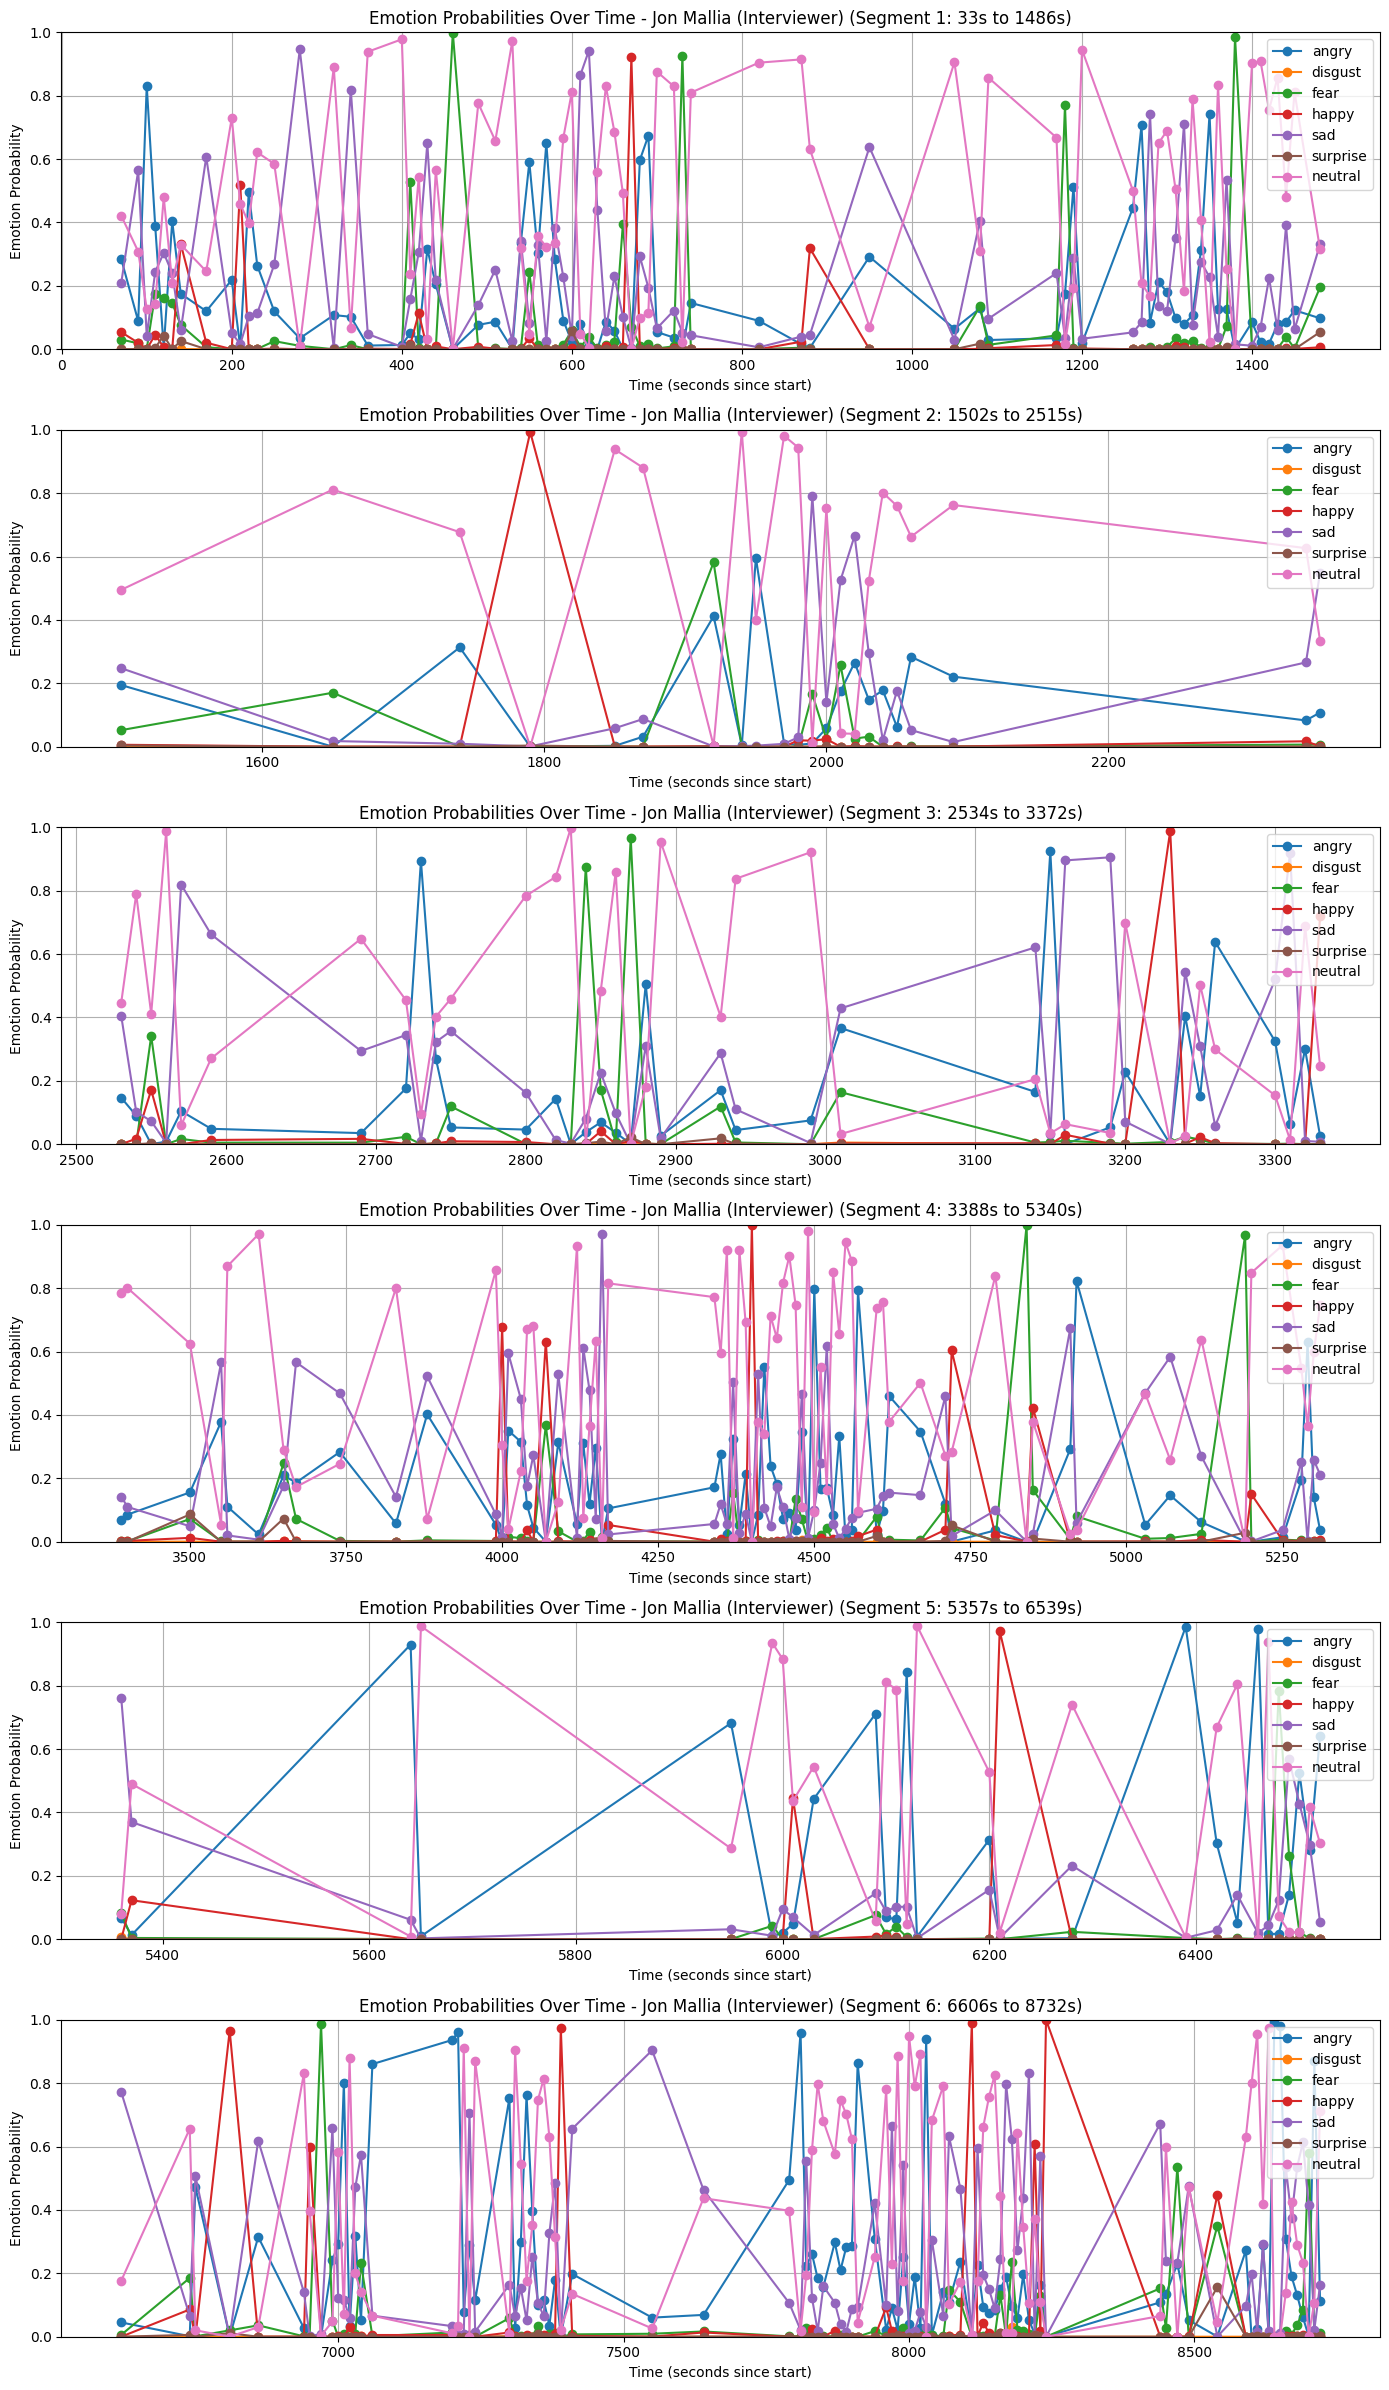

In [285]:
# === 1. Filter data for "interviewer" only
df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data
intermissions = [(c['start_time'], c['end_time']) for c in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end
max_time = df_interviewer["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Emotion probability columns
emotion_cols = [
    'angry_prob', 'disgust_prob', 'fear_prob', 'happy_prob',
    'sad_prob', 'surprise_prob', 'neutral_prob'
]

# === 7. Plot each segment (Emotion Probabilities)
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewer[
        (df_interviewer["timestamp_seconds"] > start_sec) &
        (df_interviewer["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by bin and compute mean of emotion probabilities
    emotion_probs = segment_df.groupby("time_bin")[emotion_cols].mean()

    # Plot
    ax = axes[i]
    for emotion in emotion_cols:
        ax.plot(emotion_probs.index, emotion_probs[emotion] / 100, label=emotion.replace("_prob", ""), marker='o')

    ax.set_title(f"Emotion Probabilities Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Emotion Probability")
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [286]:
# # === 1. Filter data for "interviewer" only
# df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end
# max_time = df_interviewer["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Emotion probability columns
# emotion_cols = [
#     'angry_prob', 'disgust_prob', 'fear_prob', 'happy_prob',
#     'sad_prob', 'surprise_prob', 'neutral_prob'
# ]

# # === 7. Plot each segment (Emotion Probabilities)
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewer[
#         (df_interviewer["timestamp_seconds"] > start_sec) &
#         (df_interviewer["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by bin and compute mean of emotion probabilities
#     emotion_probs = segment_df.groupby("time_bin")[emotion_cols].mean()

#     # Plot
#     ax = axes[i]
#     for emotion in emotion_cols:
#         ax.plot(emotion_probs.index, emotion_probs[emotion] / 100, label=emotion.replace("_prob", ""), marker='o')

#     ax.set_title(f"Emotion Probabilities Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Emotion Probability")
#     ax.set_ylim(0, 1)
#     ax.grid(True)
#     ax.legend(loc="upper right")

# plt.tight_layout()
# plt.show()

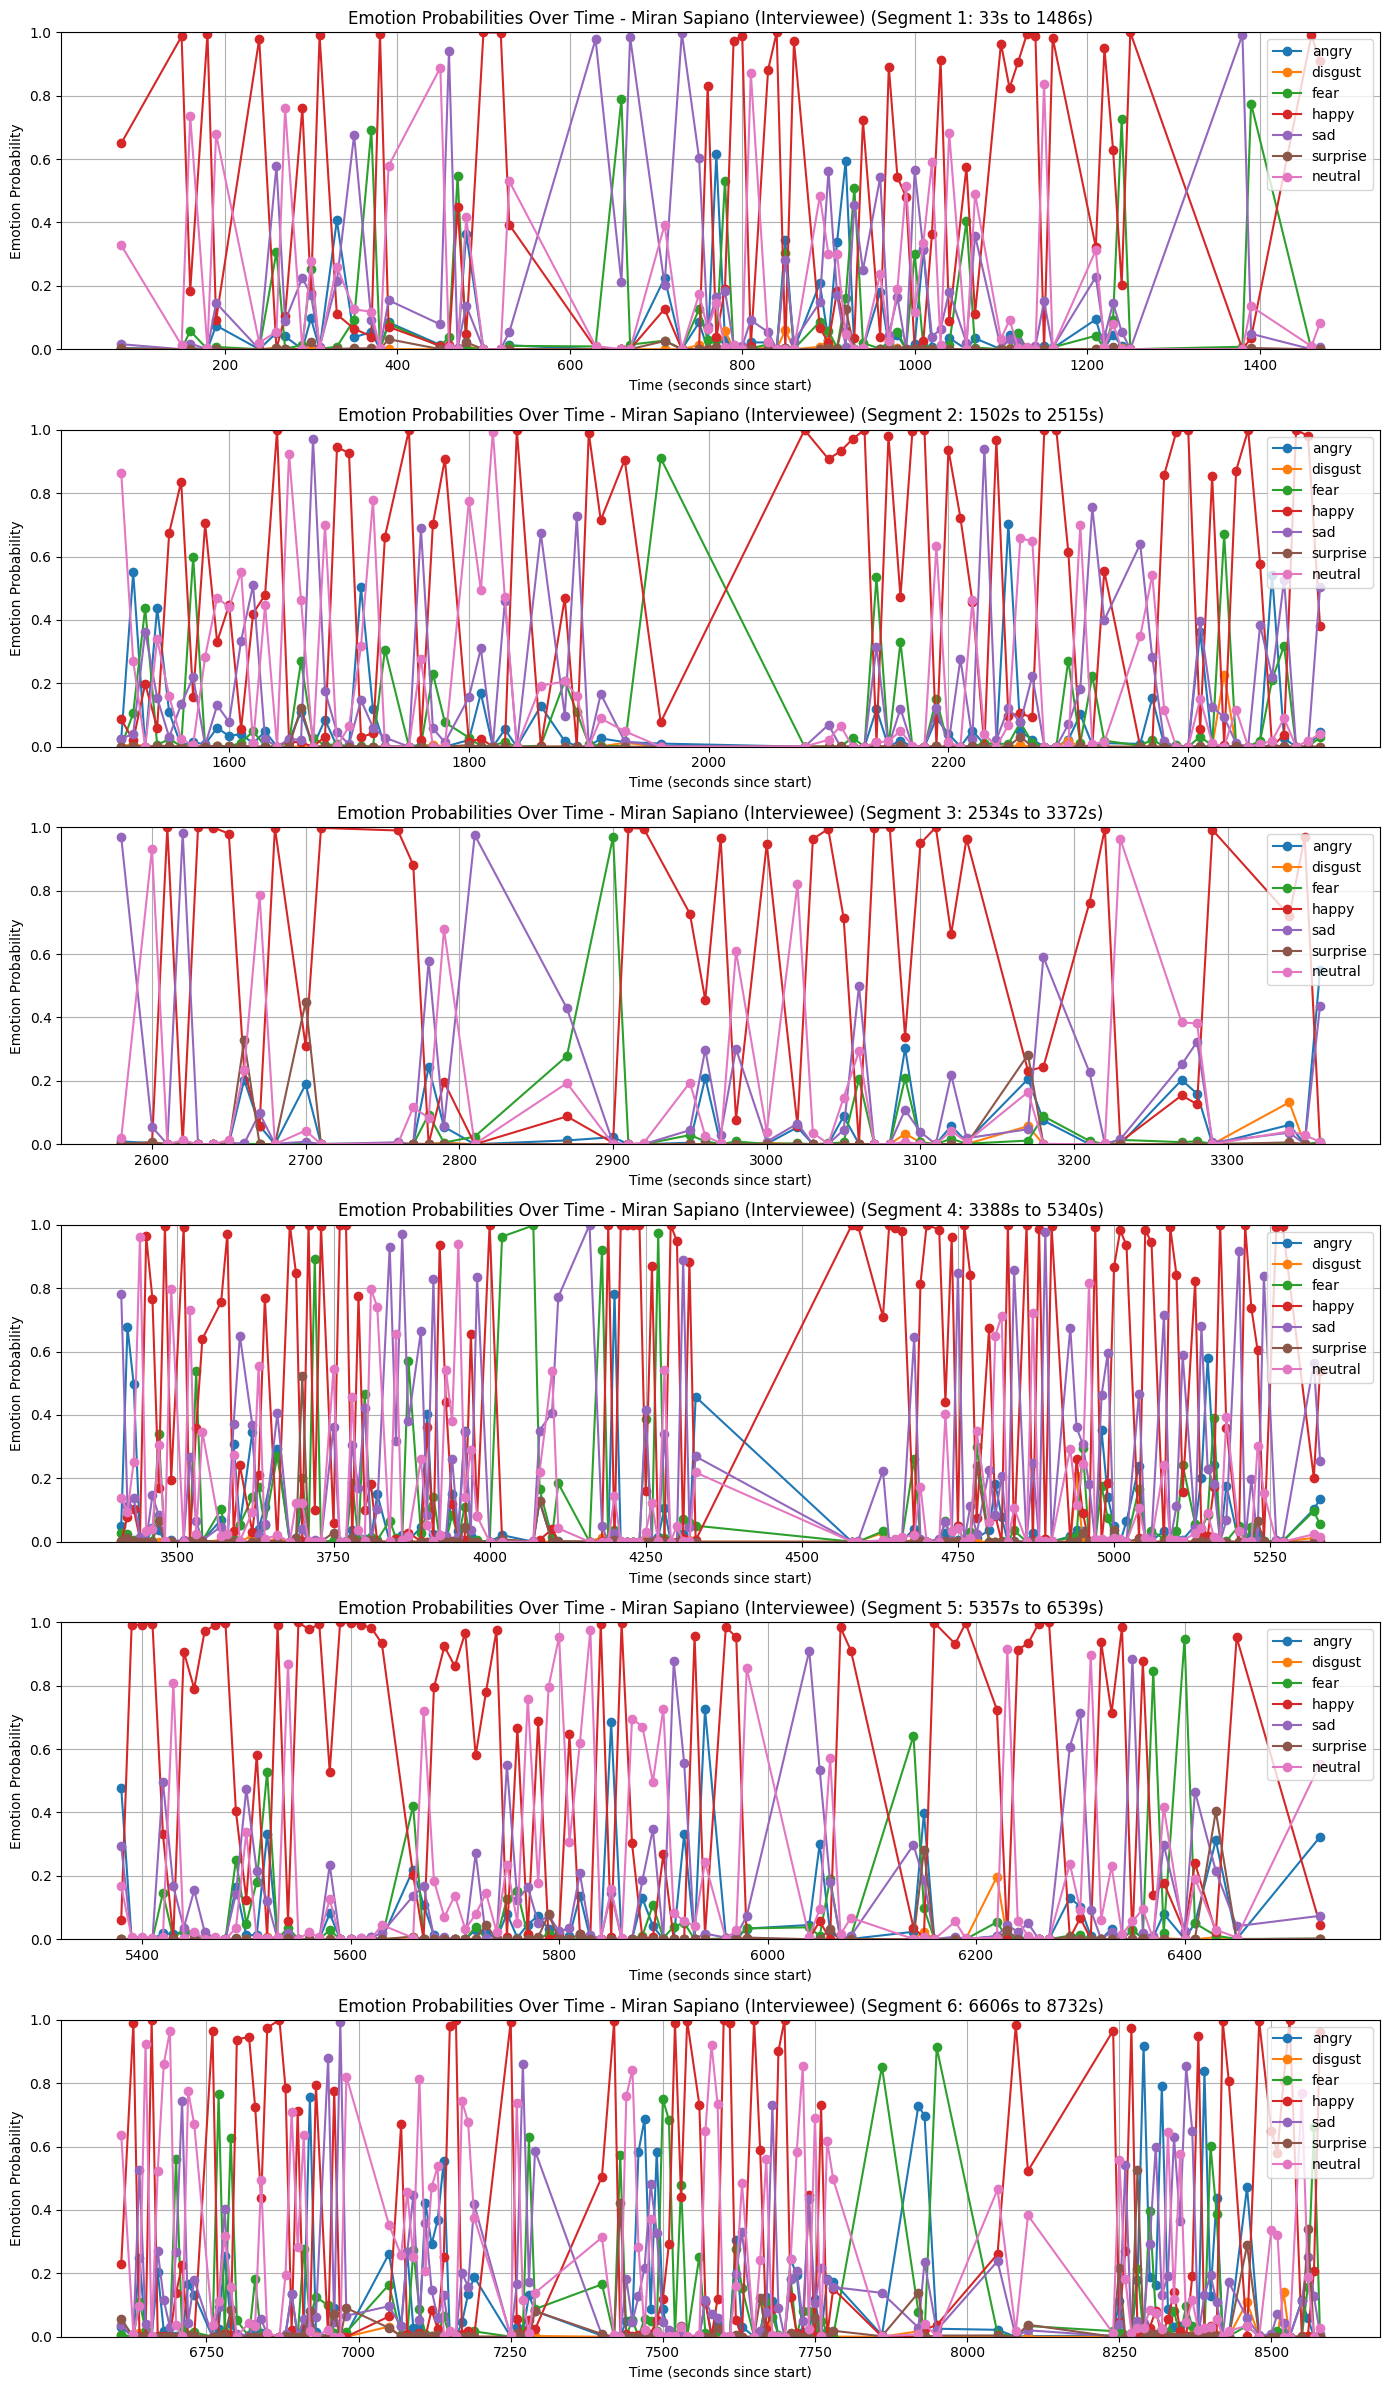

In [287]:
# === 1. Filter data for "interviewee" only
df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data
intermissions = [(c['start_time'], c['end_time']) for c in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end
max_time = df_interviewee["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Emotion probability columns
emotion_cols = [
    'angry_prob', 'disgust_prob', 'fear_prob', 'happy_prob',
    'sad_prob', 'surprise_prob', 'neutral_prob'
]

# === 7. Plot each segment (Emotion Probabilities)
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewee[
        (df_interviewee["timestamp_seconds"] > start_sec) &
        (df_interviewee["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by bin and compute mean of emotion probabilities
    emotion_probs = segment_df.groupby("time_bin")[emotion_cols].mean()

    # Plot
    ax = axes[i]
    for emotion in emotion_cols:
        ax.plot(emotion_probs.index, emotion_probs[emotion] / 100, label=emotion.replace("_prob", ""), marker='o')

    ax.set_title(f"Emotion Probabilities Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Emotion Probability")
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [288]:
# # === 1. Filter data for "interviewee" only
# df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end
# max_time = df_interviewee["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Emotion probability columns
# emotion_cols = [
#     'angry_prob', 'disgust_prob', 'fear_prob', 'happy_prob',
#     'sad_prob', 'surprise_prob', 'neutral_prob'
# ]

# # === 7. Plot each segment (Emotion Probabilities)
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewee[
#         (df_interviewee["timestamp_seconds"] > start_sec) &
#         (df_interviewee["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by bin and compute mean of emotion probabilities
#     emotion_probs = segment_df.groupby("time_bin")[emotion_cols].mean()

#     # Plot
#     ax = axes[i]
#     for emotion in emotion_cols:
#         ax.plot(emotion_probs.index, emotion_probs[emotion] / 100, label=emotion.replace("_prob", ""), marker='o')

#     ax.set_title(f"Emotion Probabilities Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Emotion Probability")
#     ax.set_ylim(0, 1)
#     ax.grid(True)
#     ax.legend(loc="upper right")

# plt.tight_layout()
# plt.show()

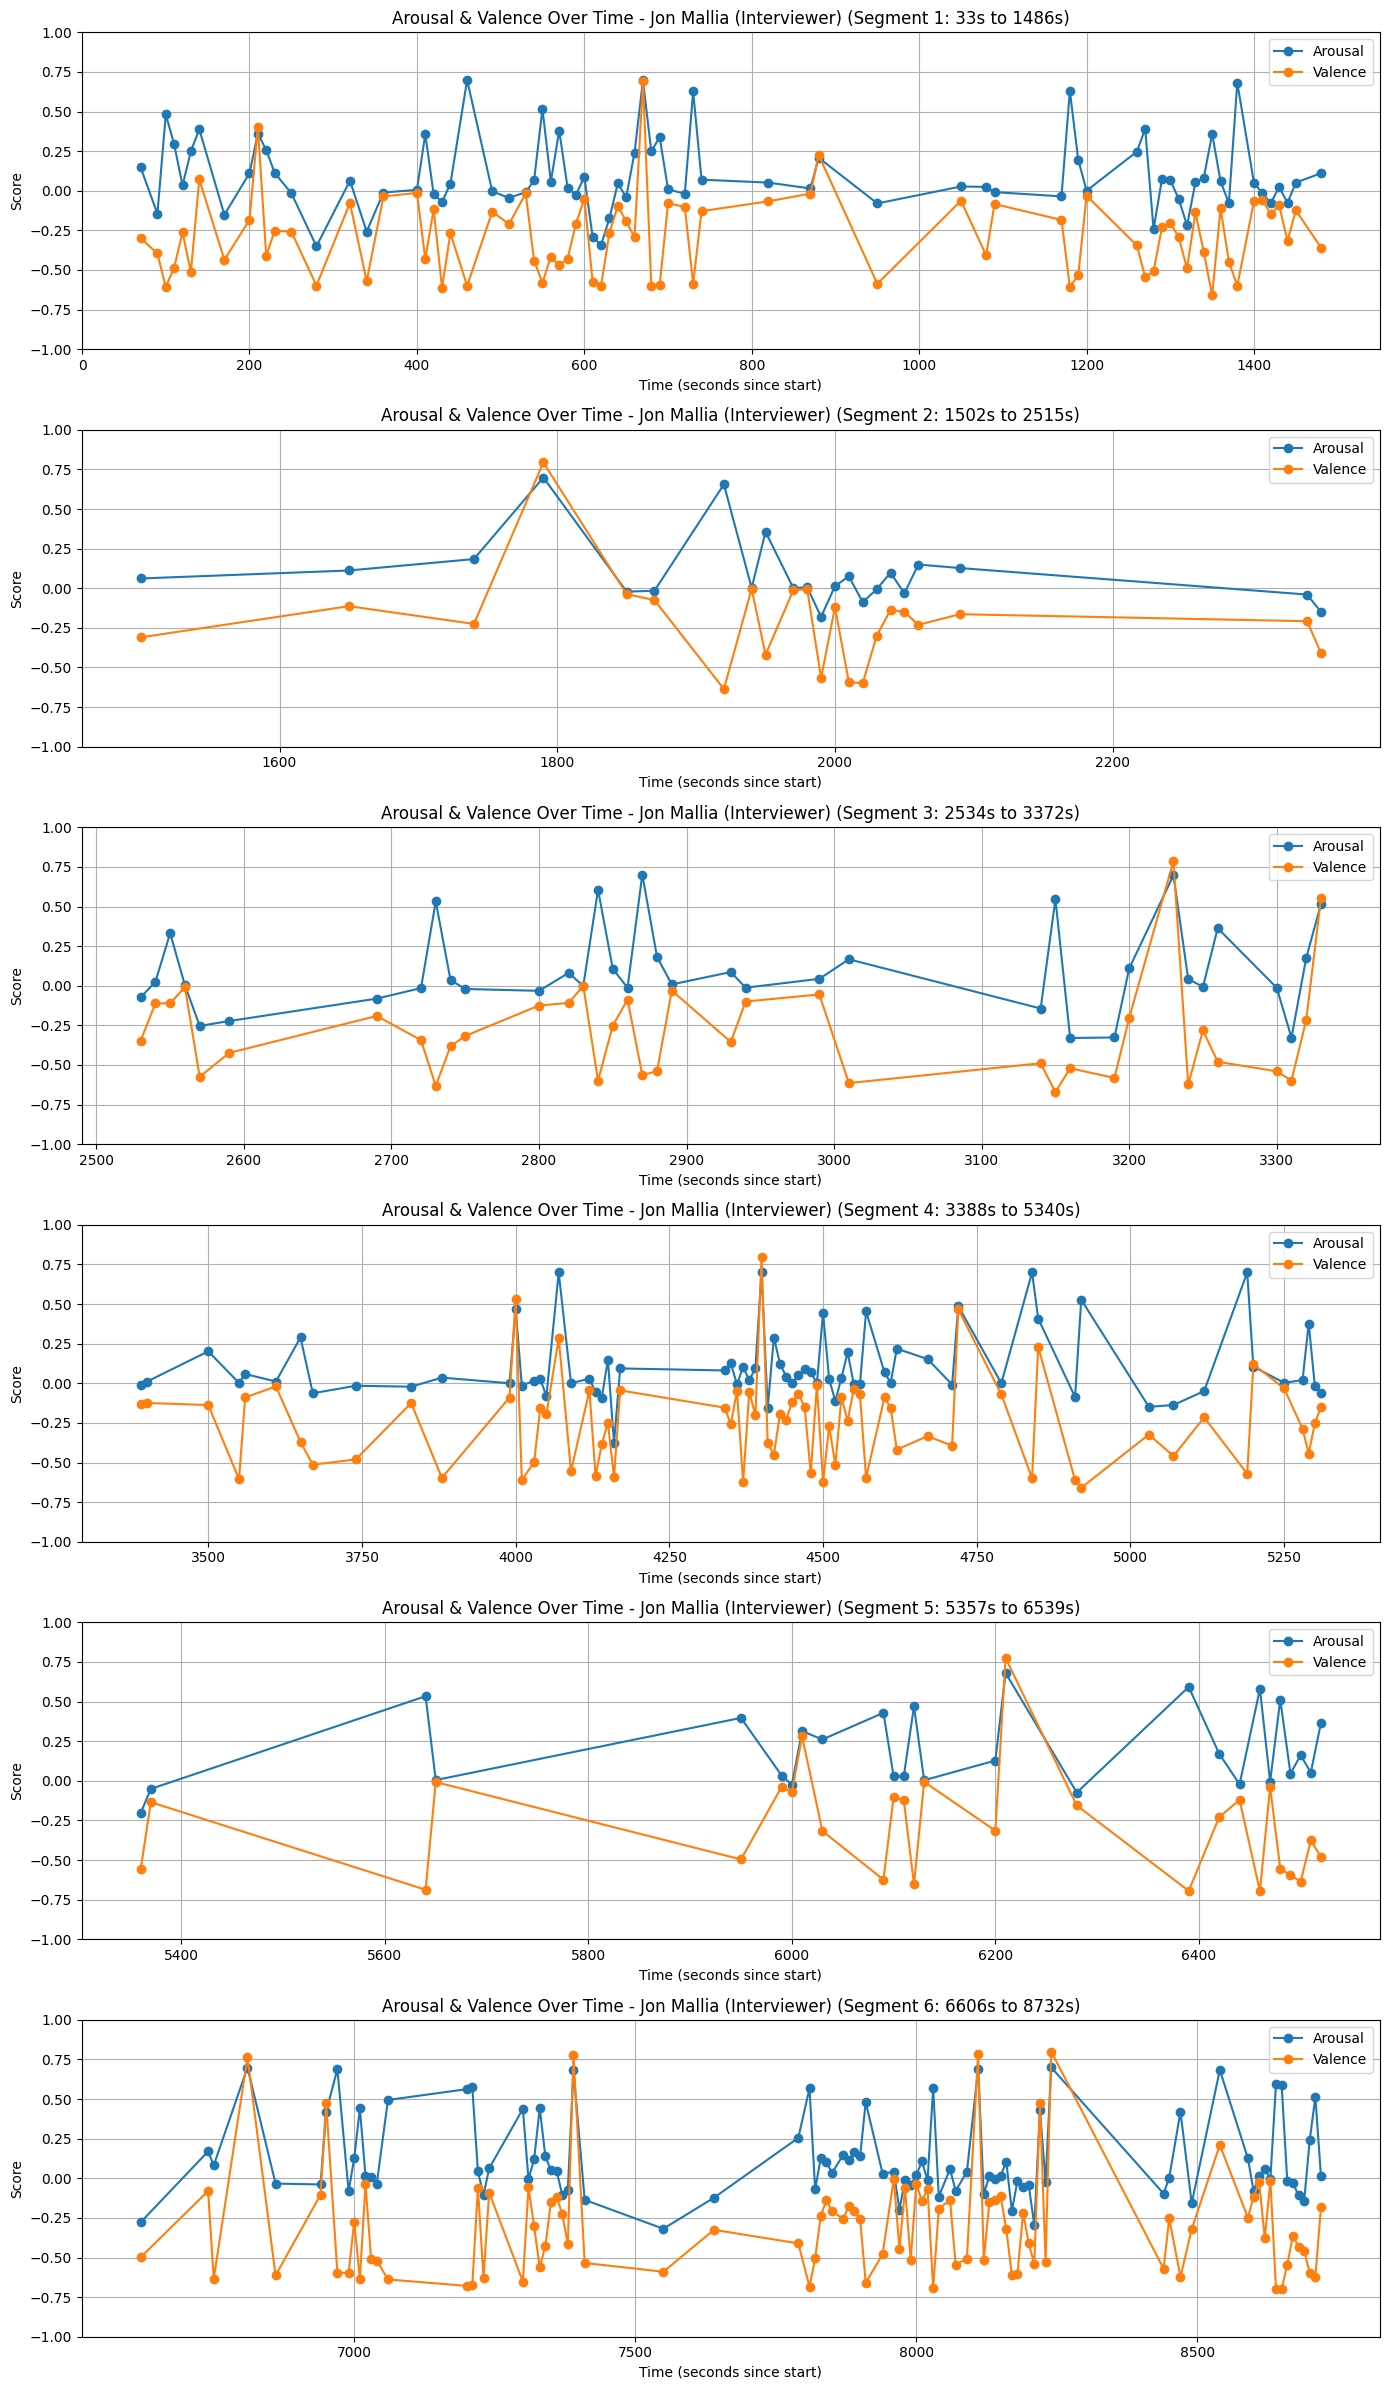

In [289]:
# === 1. Filter data for "interviewer" only
df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data from JSON
intermissions = [(commercial['start_time'], commercial['end_time']) for commercial in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end

# Add final segment if needed
max_time = df_interviewer["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Plot each segment
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewer[
        (df_interviewer["timestamp_seconds"] > start_sec) &
        (df_interviewer["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by time_bin
    avg_stats = segment_df.groupby("time_bin")[["arousal", "valence"]].mean()

    # Plot
    ax = axes[i]
    ax.plot(avg_stats.index, avg_stats["arousal"], label="Arousal", marker='o')
    ax.plot(avg_stats.index, avg_stats["valence"], label="Valence", marker='o')
    ax.set_title(f"Arousal & Valence Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Score")
    ax.set_ylim(-1, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [290]:
# # === 1. Filter data for "interviewer" only
# df_interviewer = df_rois_csv[df_rois_csv["person_classified"] == "interviewer"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewer["timestamp_seconds"] = df_interviewer["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data from JSON
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end

# # Add final segment if needed
# max_time = df_interviewer["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Plot each segment
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewer[
#         (df_interviewer["timestamp_seconds"] > start_sec) &
#         (df_interviewer["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by time_bin
#     avg_stats = segment_df.groupby("time_bin")[["arousal", "valence"]].mean()

#     # Plot
#     ax = axes[i]
#     ax.plot(avg_stats.index, avg_stats["arousal"], label="Arousal", marker='o')
#     ax.plot(avg_stats.index, avg_stats["valence"], label="Valence", marker='o')
#     ax.set_title(f"Arousal & Valence Over Time - {interviewer_data[video_chosen_basename]} (Interviewer) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Score")
#     ax.set_ylim(-1, 1)
#     ax.grid(True)
#     ax.legend()

# plt.tight_layout()
# plt.show()

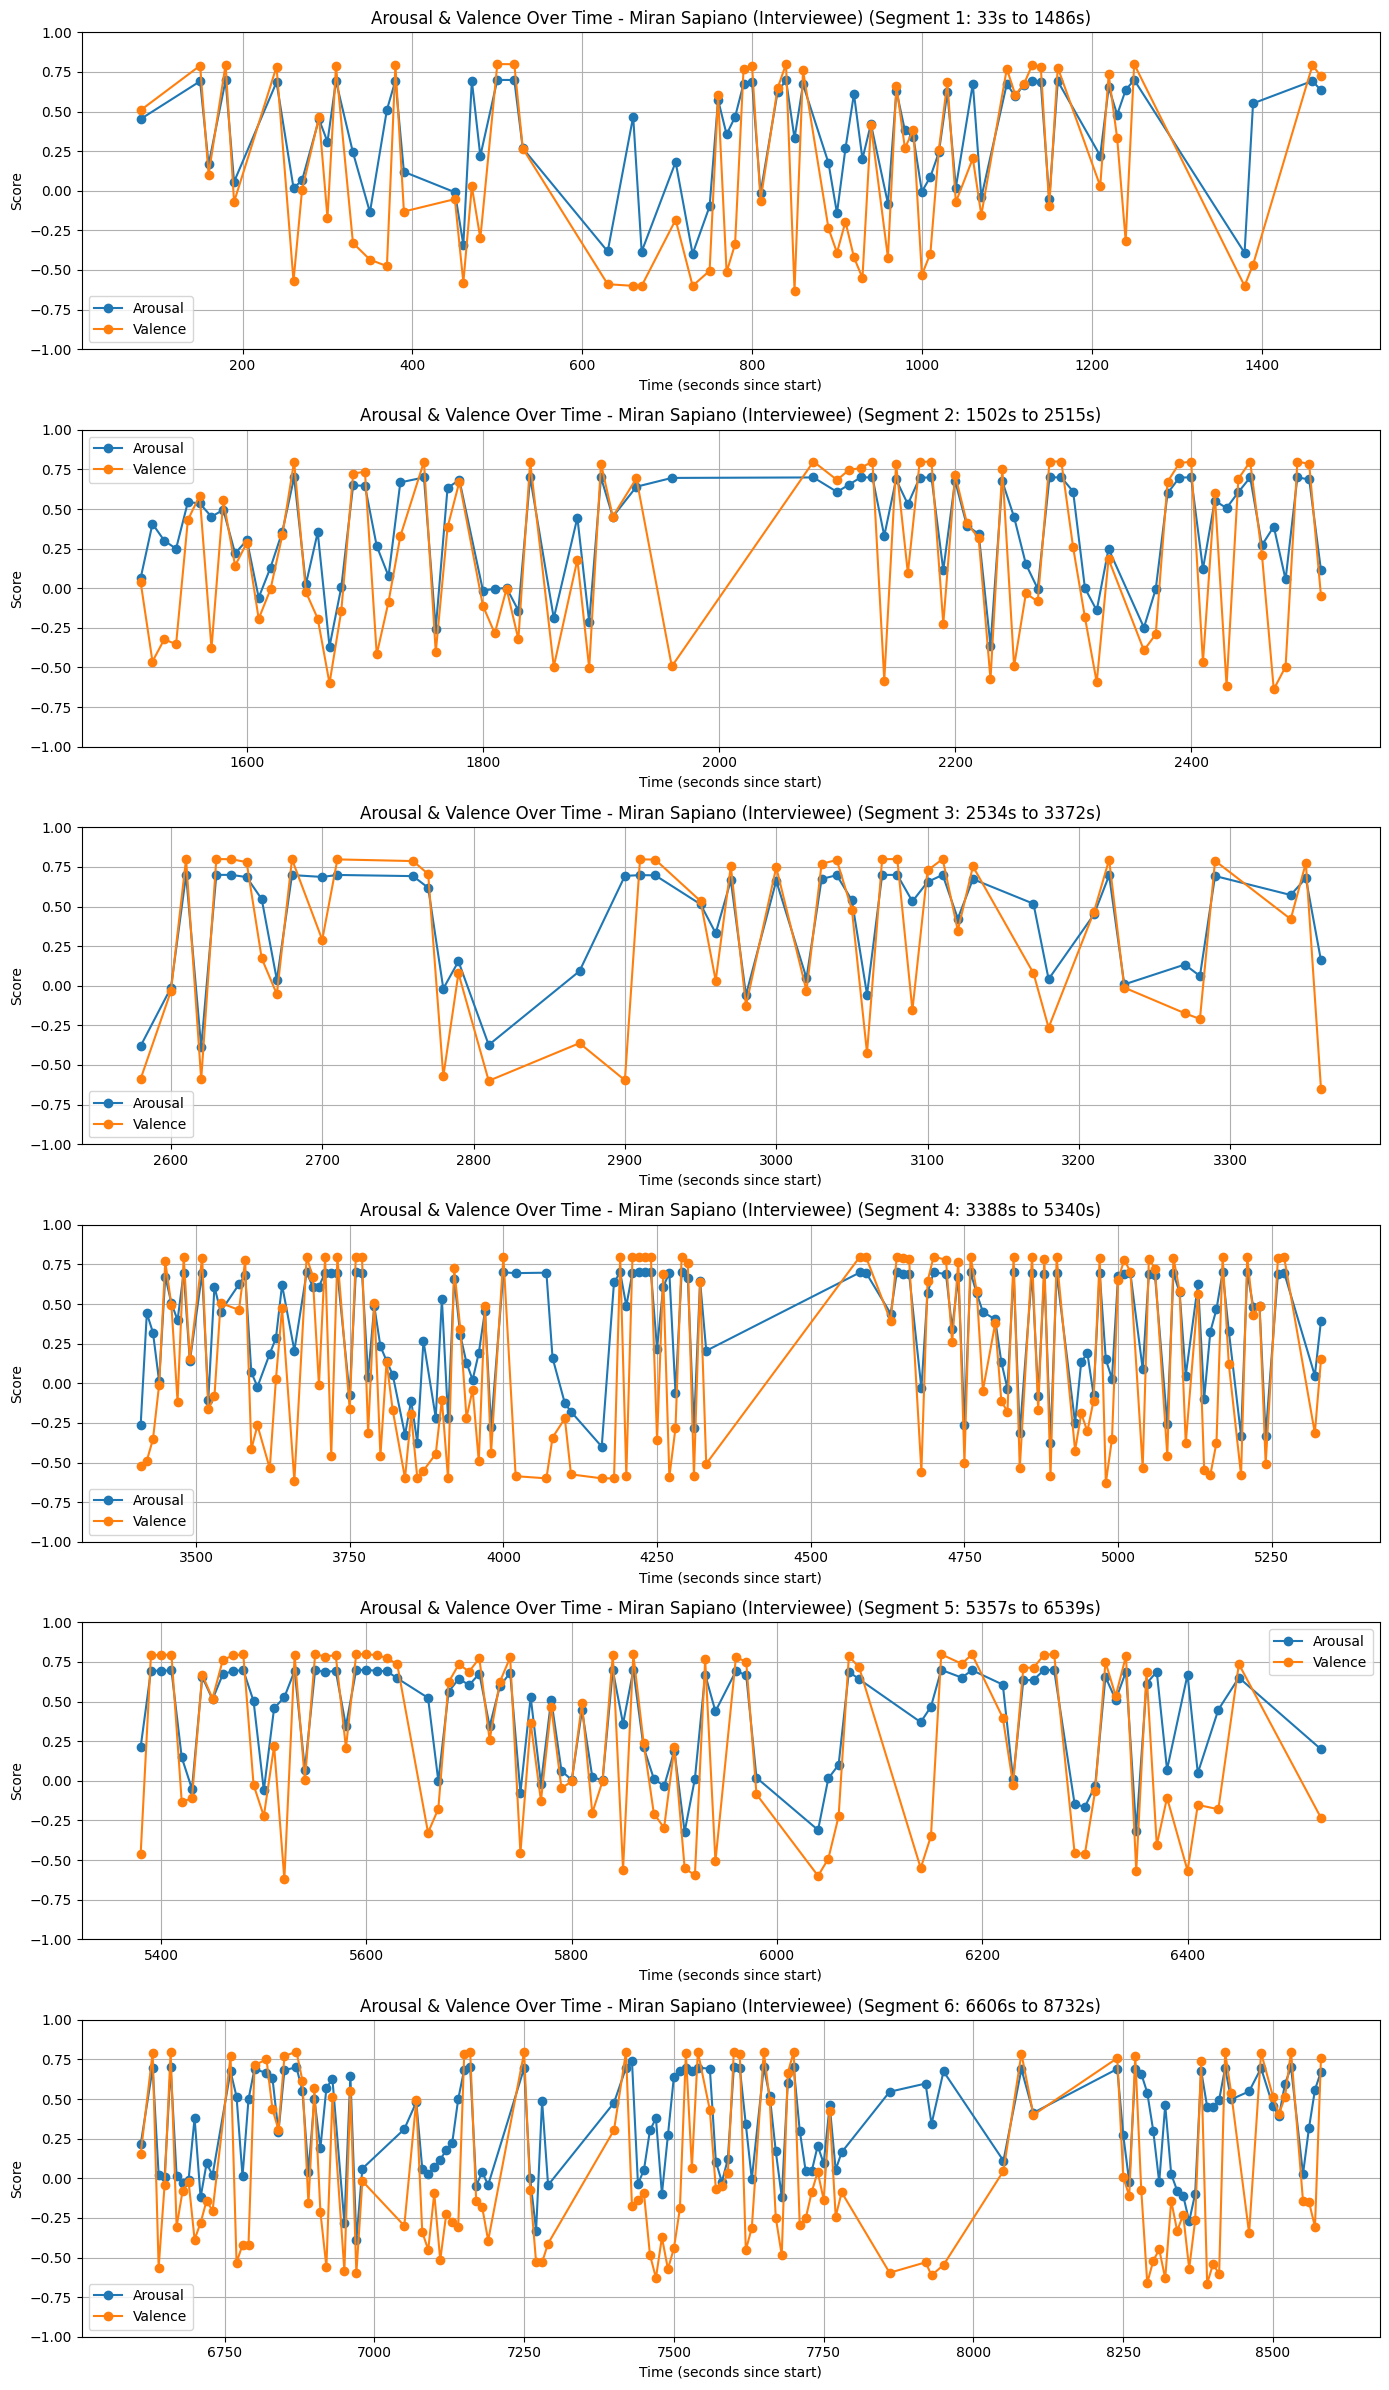

In [291]:
# === 1. Filter data for "interviewer" only
df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# === 2. Convert "frame_timestamp" to seconds
def time_to_seconds(t):
    parts = list(map(int, t.split(":")))
    while len(parts) < 3:
        parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
    h, m, s = parts
    return h * 3600 + m * 60 + s

df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# === 3. Intermission data from JSON
intermissions = [(commercial['start_time'], commercial['end_time']) for commercial in intermission_data['commercial_times']]
intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# === 4. Compute non-intermission segments
non_intermission_segments = []
previous_end = 0
for start, end in intermission_secs:
    if previous_end < start:
        non_intermission_segments.append((previous_end, start))
    previous_end = end

# Add final segment if needed
max_time = df_interviewee["timestamp_seconds"].max()
if previous_end < max_time:
    non_intermission_segments.append((previous_end, max_time))

# === 5. Set binning interval (seconds)
interval = 10  # 10 seconds

# === 6. Plot each segment
fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# Ensure axes is iterable
if len(non_intermission_segments) == 1:
    axes = [axes]

for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
    # Filter this segment
    segment_df = df_interviewee[
        (df_interviewee["timestamp_seconds"] > start_sec) &
        (df_interviewee["timestamp_seconds"] <= end_sec)
    ].copy()

    if segment_df.empty:
        continue

    # Bin the time
    segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

    # Group by time_bin
    avg_stats = segment_df.groupby("time_bin")[["arousal", "valence"]].mean()

    # Plot
    ax = axes[i]
    ax.plot(avg_stats.index, avg_stats["arousal"], label="Arousal", marker='o')
    ax.plot(avg_stats.index, avg_stats["valence"], label="Valence", marker='o')
    ax.set_title(f"Arousal & Valence Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {i+1}: {start_sec}s to {end_sec}s)")
    ax.set_xlabel("Time (seconds since start)")
    ax.set_ylabel("Score")
    ax.set_ylim(-1, 1)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [292]:
# # === 1. Filter data for "interviewer" only
# df_interviewee = df_rois_csv[df_rois_csv["person_classified"] == "interviewee"].copy()

# # === 2. Convert "frame_timestamp" to seconds
# def time_to_seconds(t):
#     parts = list(map(int, t.split(":")))
#     while len(parts) < 3:
#         parts.insert(0, 0)  # prepend 0s if format is mm:ss or ss
#     h, m, s = parts
#     return h * 3600 + m * 60 + s

# df_interviewee["timestamp_seconds"] = df_interviewee["frame_timestamp"].apply(time_to_seconds)

# # === 3. Intermission data from JSON
# intermissions = [
#     ("0:00:00", "0:38:50"),
#     ("0:40:10", "2:26:43")
# ]
# intermission_secs = [(time_to_seconds(start), time_to_seconds(end)) for start, end in intermissions]

# # === 4. Compute non-intermission segments
# non_intermission_segments = []
# previous_end = 0
# for start, end in intermission_secs:
#     if previous_end < start:
#         non_intermission_segments.append((previous_end, start))
#     previous_end = end

# # Add final segment if needed
# max_time = df_interviewee["timestamp_seconds"].max()
# if previous_end < max_time:
#     non_intermission_segments.append((previous_end, max_time))

# # === 5. Set binning interval (seconds)
# interval = 10  # 10 seconds

# # === 6. Plot each segment
# fig, axes = plt.subplots(len(non_intermission_segments), 1, figsize=(14, 4 * len(non_intermission_segments)), sharey=False)

# # Ensure axes is iterable
# if len(non_intermission_segments) == 1:
#     axes = [axes]

# for i, (start_sec, end_sec) in enumerate(non_intermission_segments):
#     # Filter this segment
#     segment_df = df_interviewee[
#         (df_interviewee["timestamp_seconds"] > start_sec) &
#         (df_interviewee["timestamp_seconds"] <= end_sec)
#     ].copy()

#     if segment_df.empty:
#         continue

#     # Bin the time
#     segment_df["time_bin"] = (segment_df["timestamp_seconds"] // interval) * interval

#     # Group by time_bin
#     avg_stats = segment_df.groupby("time_bin")[["arousal", "valence"]].mean()

#     # Plot
#     ax = axes[i]
#     ax.plot(avg_stats.index, avg_stats["arousal"], label="Arousal", marker='o')
#     ax.plot(avg_stats.index, avg_stats["valence"], label="Valence", marker='o')
#     ax.set_title(f"Arousal & Valence Over Time - {interviewee_data[video_chosen_basename]} (Interviewee) (Segment {4+1}: {start_sec}s to {end_sec}s)")
#     ax.set_xlabel("Time (seconds since start)")
#     ax.set_ylabel("Score")
#     ax.set_ylim(-1, 1)
#     ax.grid(True)
#     ax.legend()

# plt.tight_layout()
# plt.show()